#[UCI Heart Disease Data](https://www.kaggle.com/datasets/redwankarimsony/heart-disease-data)(Kaggle) - klasyfikacja choroby serca



## 1. WPROWADZENIE

### 1.1 Cel projektu
Celem projektu jest zbudowanie modelu klasyfikacyjnego do przewidywania
obecności choroby serca na podstawie danych klinicznych pacjentów.

### 1.2 Opis zbioru danych
Zbiór UCI Heart Disease zawiera dane 920 pacjentów z 4 ośrodków medycznych:
- Cleveland Clinic
- Hungarian Institute of Cardiology
- V.A. Medical Center, Long Beach
- University Hospital, Zurich, Switzerland

Dataset charakteryzuje się:
- 16 cechami (8 numerycznych, 8 kategorycznych)
- Znaczną liczbą brakujących wartości (6-66% w niektórych kolumnach)
- Zmienną docelową 'num' (0-4, gdzie 0=zdrowy, >0=choroba), którą zastąpiono zbinaryzowaną zmienną has_disease będącą naszym targetem klasyfikacyjnym

In [55]:
!python3 --version

Python 3.12.12


#DODAĆ ZBIORCZY IMPORT NA KONIEC

In [56]:
# =============================================================================
# IMPORTY
# =============================================================================

# Podstawowe
import os
import numpy as np
import pandas as pd
from collections import Counter

# Sklearn - preprocessing
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OrdinalEncoder

# Sklearn - modele
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.base import clone

# Zewnętrzne modele
try:
    from xgboost import XGBClassifier
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False

try:
    from lightgbm import LGBMClassifier
    LIGHTGBM_AVAILABLE = True
except ImportError:
    LIGHTGBM_AVAILABLE = False

# Wizualizacje
import matplotlib.pyplot as plt
import seaborn as sns

# Konfiguracja wyświetlania
pd.set_option('display.max_columns', None)
plt.style.use('default')

In [57]:
import kagglehub
import os
import pandas as pd

path = kagglehub.dataset_download("redwankarimsony/heart-disease-data")

print("Path to dataset files:", path)
print(os.listdir(path))

df = pd.read_csv(os.path.join(path, "heart_disease_uci.csv"))

df.head()

Using Colab cache for faster access to the 'heart-disease-data' dataset.
Path to dataset files: /kaggle/input/heart-disease-data
['heart_disease_uci.csv']


,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB


#Wymiary
Rekordy: 920
Kolumny: 16 cech

#Opis cech:

###Numeryczne (int64 / float64): 8 kolumn

id – unikalny identyfikator pacjenta

age – wiek pacjenta

trestbps – ciśnienie krwi w spoczynku

chol – cholesterol w mg/dl

thalach – maksymalne tętno osiągnięte

oldpeak – ST depression wywołane wysiłkiem

ca – liczba naczyń głównych pokolorowanych fluoroskopowo

num – przewidywana etykieta choroby serca


###Kategoryczne / obiektowe (object): 8 kolumn

sex – płeć

dataset – pochodzenie badania

cp – typ bólu w klatce piersiowej

fbs – cukier na czczo > 120 mg/dl (True/False)

restecg – wynik EKG w spoczynku

exang – dławica wywołana wysiłkiem

slope – nachylenie ST segment

thal – typ defektu (normal, fixed defect, reversible defect)


###Brakujące dane

trestbps – 861/920 → ok. 6.4% braków

chol – 890/920 → ok. 3.3% braków

fbs – 830/920 → ok. 9.8% braków

slope – 611/920 → ok. 33.5% braków

ca – 309/920 → ok. 66.4% braków

thal – 434/920 → ok. 52.8% braków

In [59]:
n_rows, n_cols = df.shape
print(f"\nLiczba rekordów: {n_rows}")
print(f"Liczba cech (kolumn): {n_cols}")

print("\n--- Przykładowe wiersze ---")
#print(df.head())
print(df.sample(5))

print("\n--- Statystyki opisowe ---")
print(df.describe())



Liczba rekordów: 920
Liczba cech (kolumn): 16

--- Przykładowe wiersze ---
      id  age     sex        dataset               cp  trestbps   chol    fbs  \
233  234   74  Female      Cleveland  atypical angina     120.0  269.0  False   
450  451   54    Male        Hungary   typical angina     120.0  171.0  False   
487  488   61  Female        Hungary     asymptomatic     130.0  294.0  False   
884  885   51    Male  VA Long Beach     asymptomatic       NaN    NaN   True   
411  412   49    Male        Hungary     asymptomatic     140.0    NaN  False   

              restecg  thalch  exang  oldpeak      slope   ca  \
233    lv hypertrophy   121.0   True      0.2  upsloping  1.0   
450            normal   137.0  False      2.0  upsloping  NaN   
487  st-t abnormality   120.0   True      1.0       flat  NaN   
884    lv hypertrophy     NaN    NaN      NaN        NaN  NaN   
411            normal   130.0  False      0.0        NaN  NaN   

                  thal  num  
233             

In [60]:
import numpy as np

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

target_col = 'num' if 'num' in df.columns else None

if target_col:
    if target_col in num_cols:
        num_cols.remove(target_col)
    if target_col in cat_cols:
        cat_cols.remove(target_col)

print("Kolumny numeryczne:", num_cols)
print("Kolumny kategoryczne:", cat_cols)
print("Zmienna docelowa:", target_col)


Kolumny numeryczne: ['id', 'age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']
Kolumny kategoryczne: ['sex', 'dataset', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']
Zmienna docelowa: num


In [61]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer, KNNImputer

num_df = df[num_cols].copy()
cat_df = df[cat_cols].copy()

half = len(num_cols) // 2
num_easy = num_cols[:half]
num_hard = num_cols[half:]

simple_imputer = SimpleImputer(strategy='mean')
num_easy_imputed = pd.DataFrame(simple_imputer.fit_transform(df[num_easy]), columns=num_easy)

knn_imputer = KNNImputer(n_neighbors=5)
num_hard_imputed = pd.DataFrame(knn_imputer.fit_transform(df[num_hard]), columns=num_hard)

num_imputed = pd.concat([num_easy_imputed, num_hard_imputed], axis=1)

cat_imputer = SimpleImputer(strategy='most_frequent')
cat_imputed = pd.DataFrame(cat_imputer.fit_transform(cat_df), columns=cat_cols)

df_imputed = pd.concat([num_imputed, cat_imputed], axis=1)

print("✅ Dane uzupełnione:")
print(df_imputed.info())

✅ Dane uzupełnione:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    float64
 1   age       920 non-null    float64
 2   trestbps  920 non-null    float64
 3   chol      920 non-null    float64
 4   thalch    920 non-null    float64
 5   oldpeak   920 non-null    float64
 6   ca        920 non-null    float64
 7   sex       920 non-null    object 
 8   dataset   920 non-null    object 
 9   cp        920 non-null    object 
 10  fbs       920 non-null    object 
 11  restecg   920 non-null    object 
 12  exang     920 non-null    object 
 13  slope     920 non-null    object 
 14  thal      920 non-null    object 
dtypes: float64(7), object(8)
memory usage: 107.9+ KB
None


In [62]:
from sklearn.preprocessing import OrdinalEncoder

df_encoded = df_imputed.copy()

ordinal_features = {
    'cp': ['asymptomatic', 'non-anginal', 'atypical angina', 'typical angina'],
    'restecg': ['normal', 'st-t abnormality', 'lv hypertrophy'],
    'slope': ['upsloping', 'flat', 'downsloping'],
    'thal': ['normal', 'reversable defect', 'fixed defect']
}

encoder = OrdinalEncoder(categories=[ordinal_features[col] for col in ordinal_features])
df_encoded[list(ordinal_features.keys())] = encoder.fit_transform(df_encoded[list(ordinal_features.keys())])

nominal_features = ['sex', 'dataset', 'fbs', 'exang']
df_encoded = pd.get_dummies(df_encoded, columns=nominal_features, drop_first=True)

print("Wszystkie kolumny zakodowane numerycznie:")
print(df_encoded.info())
df_encoded.head()


Wszystkie kolumny zakodowane numerycznie:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     920 non-null    float64
 1   age                    920 non-null    float64
 2   trestbps               920 non-null    float64
 3   chol                   920 non-null    float64
 4   thalch                 920 non-null    float64
 5   oldpeak                920 non-null    float64
 6   ca                     920 non-null    float64
 7   cp                     920 non-null    float64
 8   restecg                920 non-null    float64
 9   slope                  920 non-null    float64
 10  thal                   920 non-null    float64
 11  sex_Male               920 non-null    bool   
 12  dataset_Hungary        920 non-null    bool   
 13  dataset_Switzerland    920 non-null    bool   
 14  dataset_VA Long 

,id,age,trestbps,chol,thalch,oldpeak,ca,cp,restecg,slope,thal,sex_Male,dataset_Hungary,dataset_Switzerland,dataset_VA Long Beach,fbs_True,exang_True
0,1.0,63.0,145.0,233.0,150.0,2.3,0.0,3.0,2.0,2.0,2.0,True,False,False,False,True,False
1,2.0,67.0,160.0,286.0,108.0,1.5,3.0,0.0,2.0,1.0,0.0,True,False,False,False,False,True
2,3.0,67.0,120.0,229.0,129.0,2.6,2.0,0.0,2.0,1.0,1.0,True,False,False,False,False,True
3,4.0,37.0,130.0,250.0,187.0,3.5,0.0,1.0,0.0,2.0,0.0,True,False,False,False,False,False
4,5.0,41.0,130.0,204.0,172.0,1.4,0.0,2.0,2.0,0.0,0.0,False,False,False,False,False,False


Utworzone poniżej cechy(ekstrakcja):

cv_risk_score – zagregowany wskaźnik ryzyka sercowo-naczyniowego (łączący wiek, cholesterol, ciśnienie i depresję ST).

heart_reserve – wskaźnik wydolności serca (thalach względem oldpeak).

age_category – kategoria wiekowa (0–3).

triple_risk – flaga potrójnego ryzyka (chol > 240, ciśnienie > 140, wiek > 55).

exercise_tolerance – wskaźnik tolerancji wysiłku (skalowany 0–5).

In [63]:
if 'num' not in df_encoded.columns and 'num' in df.columns:
    df_encoded['num'] = df['num']

In [64]:
# =============================================================================
# FEATURE ENGINEERING - Tworzenie 5 nowych cech medycznych
# =============================================================================

# 1. Cardiovascular Risk Score
df_encoded['cv_risk_score'] = (
    (df_encoded['age'] - 40) * 0.1 +
    (df_encoded['chol'] - 200) * 0.05 +
    (df_encoded['trestbps'] - 120) * 0.08 +
    df_encoded['oldpeak'] * 2
).clip(lower=0)

# 2. Heart Reserve Capacity
df_encoded['heart_reserve'] = df_encoded['thalch'] / (df_encoded['oldpeak'] + 1)

# 3. Age Category
df_encoded['age_category'] = pd.cut(
    df_encoded['age'],
    bins=[0, 45, 55, 65, 100],
    labels=[0, 1, 2, 3]
).astype(float)

# 4. Triple Risk Flag
df_encoded['triple_risk'] = (
    (df_encoded['chol'] > 240) &
    (df_encoded['trestbps'] > 140) &
    (df_encoded['age'] > 55)
).astype(int)

# 5. Exercise Tolerance Score
df_encoded['exercise_tolerance'] = (
    (df_encoded['thalch'] > 150).astype(int) * 2 +
    (df_encoded['oldpeak'] < 1).astype(int) * 2 +
    (~df_encoded['exang_True']).astype(int)
)

cols_to_display = [
    'age', 'trestbps', 'chol', 'thalch', 'oldpeak',  # kluczowe oryginalne
    'cv_risk_score', 'heart_reserve', 'age_category',
    'triple_risk', 'exercise_tolerance', 'num'        # wszystkie nowe + target
]

print("Dodano 5 nowych cech. Aktualna liczba kolumn:", len(df_encoded.columns))
df_encoded[cols_to_display].head()

Dodano 5 nowych cech. Aktualna liczba kolumn: 23


,age,trestbps,chol,thalch,oldpeak,cv_risk_score,heart_reserve,age_category,triple_risk,exercise_tolerance,num
0,63.0,145.0,233.0,150.0,2.3,10.55,45.454545,2.0,0,1,0
1,67.0,160.0,286.0,108.0,1.5,13.20,43.200000,3.0,1,0,2
2,67.0,120.0,229.0,129.0,2.6,9.35,35.833333,3.0,0,0,1
3,37.0,130.0,250.0,187.0,3.5,10.00,41.555556,0.0,0,3,0
4,41.0,130.0,204.0,172.0,1.4,3.90,71.666667,0.0,0,3,0


## 3. FEATURE ENGINEERING

### 3.1 Uzasadnienie nowych cech

Utworzono 5 nowych cech medycznych w oparciu o dostępną literaturę:

1. **cv_risk_score** - zagregowany wskaźnik ryzyka sercowo-naczyniowego
   - Bazuje na znanych czynnikach: wiek, cholesterol, ciśnienie, ST depression
   - Wzór uwzględnia wagi oparte na znaczeniu klinicznym

2. **heart_reserve** - wskaźnik wydolności serca
   - Stosunek maksymalnego tętna do oldpeak
   - Wyższe wartości = lepsza wydolność

3. **age_category** - kategorie wiekowe ryzyka
   - Podział na grupy: <45, 45-55, 55-65, >65
   - Odzwierciedla wzrost ryzyka z wiekiem

4. **triple_risk** - flaga potrójnego ryzyka
   - Kombinacja: wysoki cholesterol + wysokie ciśnienie + starszy wiek
   - Binarna cecha wysokiego ryzyka

5. **exercise_tolerance** - tolerancja wysiłku (0-5)
   - Agreguje: wysokie thalach, niski oldpeak, brak dławicy wysiłkowej

#Imputacja i kodowanie

1. **Imputacja braków**  
   - Dane numeryczne podzielono na dwa podzbiory:
     - Podzbiór A: imputacja prostą metodą (średnia)  
     - Podzbiór B: imputacja bardziej zaawansowaną metodą (KNNImputer)  
   - Dla danych kategorycznych zastosowano imputację wartościami najczęstszymi (`most_frequent`).

2. **Kodowanie zmiennych kategorycznych**  
   - Zmienne z naturalnym porządkiem (np. `cp`, `restecg`, `slope`, `thal`) zakodowano za pomocą **OrdinalEncoder**, by zachować sens kolejności.  
   - Pozostałe zmienne nominalne (np. `sex`, `dataset`, `fbs`, `exang`) zakodowano metodą **One-Hot Encoding**, usuwając jedną referencyjną kategorię (drop_first=True), aby uniknąć współliniowości.

Po tych operacjach wszystkie cechy mają typ numeryczny (float lub bool), bez brakujących wartości — dane są gotowe do analizy statystycznej i modelowania.  


### Zmodyfikowane i zakodowane cechy

1. **`sex`** → zastąpiono przez kolumnę binarną `sex_Male`  
   - Wartość `True` oznacza mężczyznę, `False` – kobietę.  

2. **`dataset`** → zastąpiono trzema kolumnami logicznymi:  
   - `dataset_Hungary`, `dataset_Switzerland`, `dataset_VA Long Beach`  
   - Brak wartości w tych kolumnach (wszystkie `False`) oznacza dane z **Cleveland** (usunięta referencja po One-Hot Encoding).

3. **`cp` (chest pain type)** → zakodowano liczbowo metodą **OrdinalEncoder**:  
   - 0 – typical angina  
   - 1 – atypical angina  
   - 2 – non-anginal  
   - 3 – asymptomatic  

4. **`restecg`** → zakodowano liczbowo metodą **OrdinalEncoder**:  
   - 0 – normal  
   - 1 – stt abnormality  
   - 2 – lv hypertrophy  

5. **`slope`** → zakodowano liczbowo metodą **OrdinalEncoder**:  
   - 0 – upsloping  
   - 1 – flat  
   - 2 – downsloping  

6. **`thal`** → zakodowano liczbowo metodą **OrdinalEncoder**:  
   - 0 – normal  
   - 1 – fixed defect  
   - 2 – reversible defect  

7. **`fbs` i `exang`** → zastąpione przez kolumny binarne (`fbs_True`, `exang_True`)  
   - Wartość `True` oznacza odpowiednio: cukier na czczo >120 mg/dl / wystąpienie dławicy przy wysiłku.


Wszystkie pozostałe kolumny (`age`, `trestbps`, `chol`, `thalch`, `oldpeak`, `ca`) zachowały oryginalną postać liczbową (float), jedynie uzupełniono w nich brakujące wartości.


In [65]:
display(df_encoded.describe().T)

,count,mean,std,min,25%,50%,75%,max
id,920.0,460.500000,265.725422,1.0,230.7500,460.500,690.25,920.00
age,920.0,53.510870,9.424685,28.0,47.0000,54.000,60.00,77.00
trestbps,920.0,132.132404,18.443895,0.0,120.0000,130.000,140.00,200.00
chol,920.0,198.970642,109.467013,0.0,175.0000,223.000,267.00,603.00
thalch,920.0,137.741997,25.359888,60.0,120.0000,140.000,157.00,202.00
oldpeak,920.0,0.877083,1.062098,-2.6,0.0000,0.600,1.50,6.20
ca,920.0,0.766553,0.674078,0.0,0.2000,0.800,1.20,3.00
cp,920.0,0.750000,0.930969,0.0,0.0000,0.000,1.00,3.00
restecg,920.0,0.603261,0.805443,0.0,0.0000,0.000,1.00,2.00
slope,920.0,0.847826,0.516007,0.0,1.0000,1.000,1.00,2.00


In [66]:
# Rozkład wieku pacjentów + średni cholesterol w tych przedziałach
print("\n=== Rozkład wieku pacjentów ===")
age_bins = pd.cut(df_encoded['age'], bins=5)
age_distribution = df_encoded['age'].value_counts(bins=5).sort_index()

print("Liczba pacjentów w przedziałach wiekowych:")
print(age_distribution)

print("\nŚredni cholesterol (chol) w tych samych przedziałach wiekowych:")
print(df_encoded.groupby(age_bins)['chol'].mean().round(2))



=== Rozkład wieku pacjentów ===
Liczba pacjentów w przedziałach wiekowych:
(27.95, 37.8]     49
(37.8, 47.6]     190
(47.6, 57.4]     350
(57.4, 67.2]     277
(67.2, 77.0]      54
Name: count, dtype: int64

Średni cholesterol (chol) w tych samych przedziałach wiekowych:
age
(27.951, 37.8]    211.62
(37.8, 47.6]      211.81
(47.6, 57.4]      203.94
(57.4, 67.2]      186.34
(67.2, 77.0]      174.87
Name: chol, dtype: float64


/tmp/ipython-input-2671056806.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df_encoded.groupby(age_bins)['chol'].mean().round(2))


In [67]:
# Średnie wartości ciśnienia i cholesterolu w zależności od kraju pochodzenia
print("\n=== Średnie ciśnienie i cholesterol w zależności od kraju ===")
country_cols = ['dataset_Hungary', 'dataset_Switzerland', 'dataset_VA Long Beach']
df_encoded['dataset_origin'] = df_encoded[country_cols].idxmax(axis=1).replace({
    'dataset_Hungary': 'Hungary',
    'dataset_Switzerland': 'Switzerland',
    'dataset_VA Long Beach': 'VA Long Beach'
})
df_encoded.loc[(df_encoded[country_cols] == False).all(axis=1), 'dataset_origin'] = 'Cleveland'
print(df_encoded.groupby('dataset_origin')[['trestbps', 'chol']].mean().round(2))


=== Średnie ciśnienie i cholesterol w zależności od kraju ===
                trestbps    chol
dataset_origin                  
Cleveland         131.68  246.32
Hungary           132.59  247.19
Switzerland       130.24    0.00
VA Long Beach     133.31  178.73


In [68]:
print("\n=== Średnie tętno maksymalne (thalch) w zależności od płci ===")
print(df_encoded.groupby('sex_Male')['thalch'].mean().rename({True: "Mężczyźni", False: "Kobiety"}))


=== Średnie tętno maksymalne (thalch) w zależności od płci ===
sex_Male
Kobiety      146.135052
Mężczyźni    135.499225
Name: thalch, dtype: float64


In [69]:
# Częstość występowania dławicy wysiłkowej (exang) w zależności od płci
print("\n=== Dławica wysiłkowa (exang_True) w zależności od płci ===")
print(df_encoded.groupby('sex_Male')['exang_True'].mean().rename({True: "Mężczyźni", False: "Kobiety"}))


=== Dławica wysiłkowa (exang_True) w zależności od płci ===
sex_Male
Kobiety      0.221649
Mężczyźni    0.404959
Name: exang_True, dtype: float64


In [70]:
print("=== Średni wiek pacjentów z chorobą i bez choroby, z podziałem na płeć ===")

# Obliczamy średni wiek pacjentów z chorobą i bez choroby (num > 0 oznacza obecność choroby)
age_by_sex_disease = df_encoded.groupby(['sex_Male', df_encoded['num'] > 0])['age'].mean().unstack()
age_by_sex_disease.columns = ['Brak choroby', 'Choroba serca']
age_by_sex_disease.index = ['Kobiety', 'Mężczyźni']
print(age_by_sex_disease.round(1))

# Udział przypadków choroby w każdej grupie płci
print("\n=== Odsetek osób z chorobą serca w zależności od płci ===")
disease_rate_by_sex = df_encoded.groupby('sex_Male')['num'].apply(lambda x: (x > 0).mean())
disease_rate_by_sex.index = ['Kobiety', 'Mężczyźni']
print((disease_rate_by_sex * 100).round(1).astype(str) + '%')


=== Średni wiek pacjentów z chorobą i bez choroby, z podziałem na płeć ===
           Brak choroby  Choroba serca
Kobiety            51.2           56.2
Mężczyźni          50.2           55.9

=== Odsetek osób z chorobą serca w zależności od płci ===
Kobiety      25.8%
Mężczyźni    63.2%
Name: num, dtype: object


Liczba cech: 15
Cechy: ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca', 'cp', 'restecg', 'slope', 'thal', 'cv_risk_score', 'heart_reserve', 'age_category', 'triple_risk', 'exercise_tolerance']



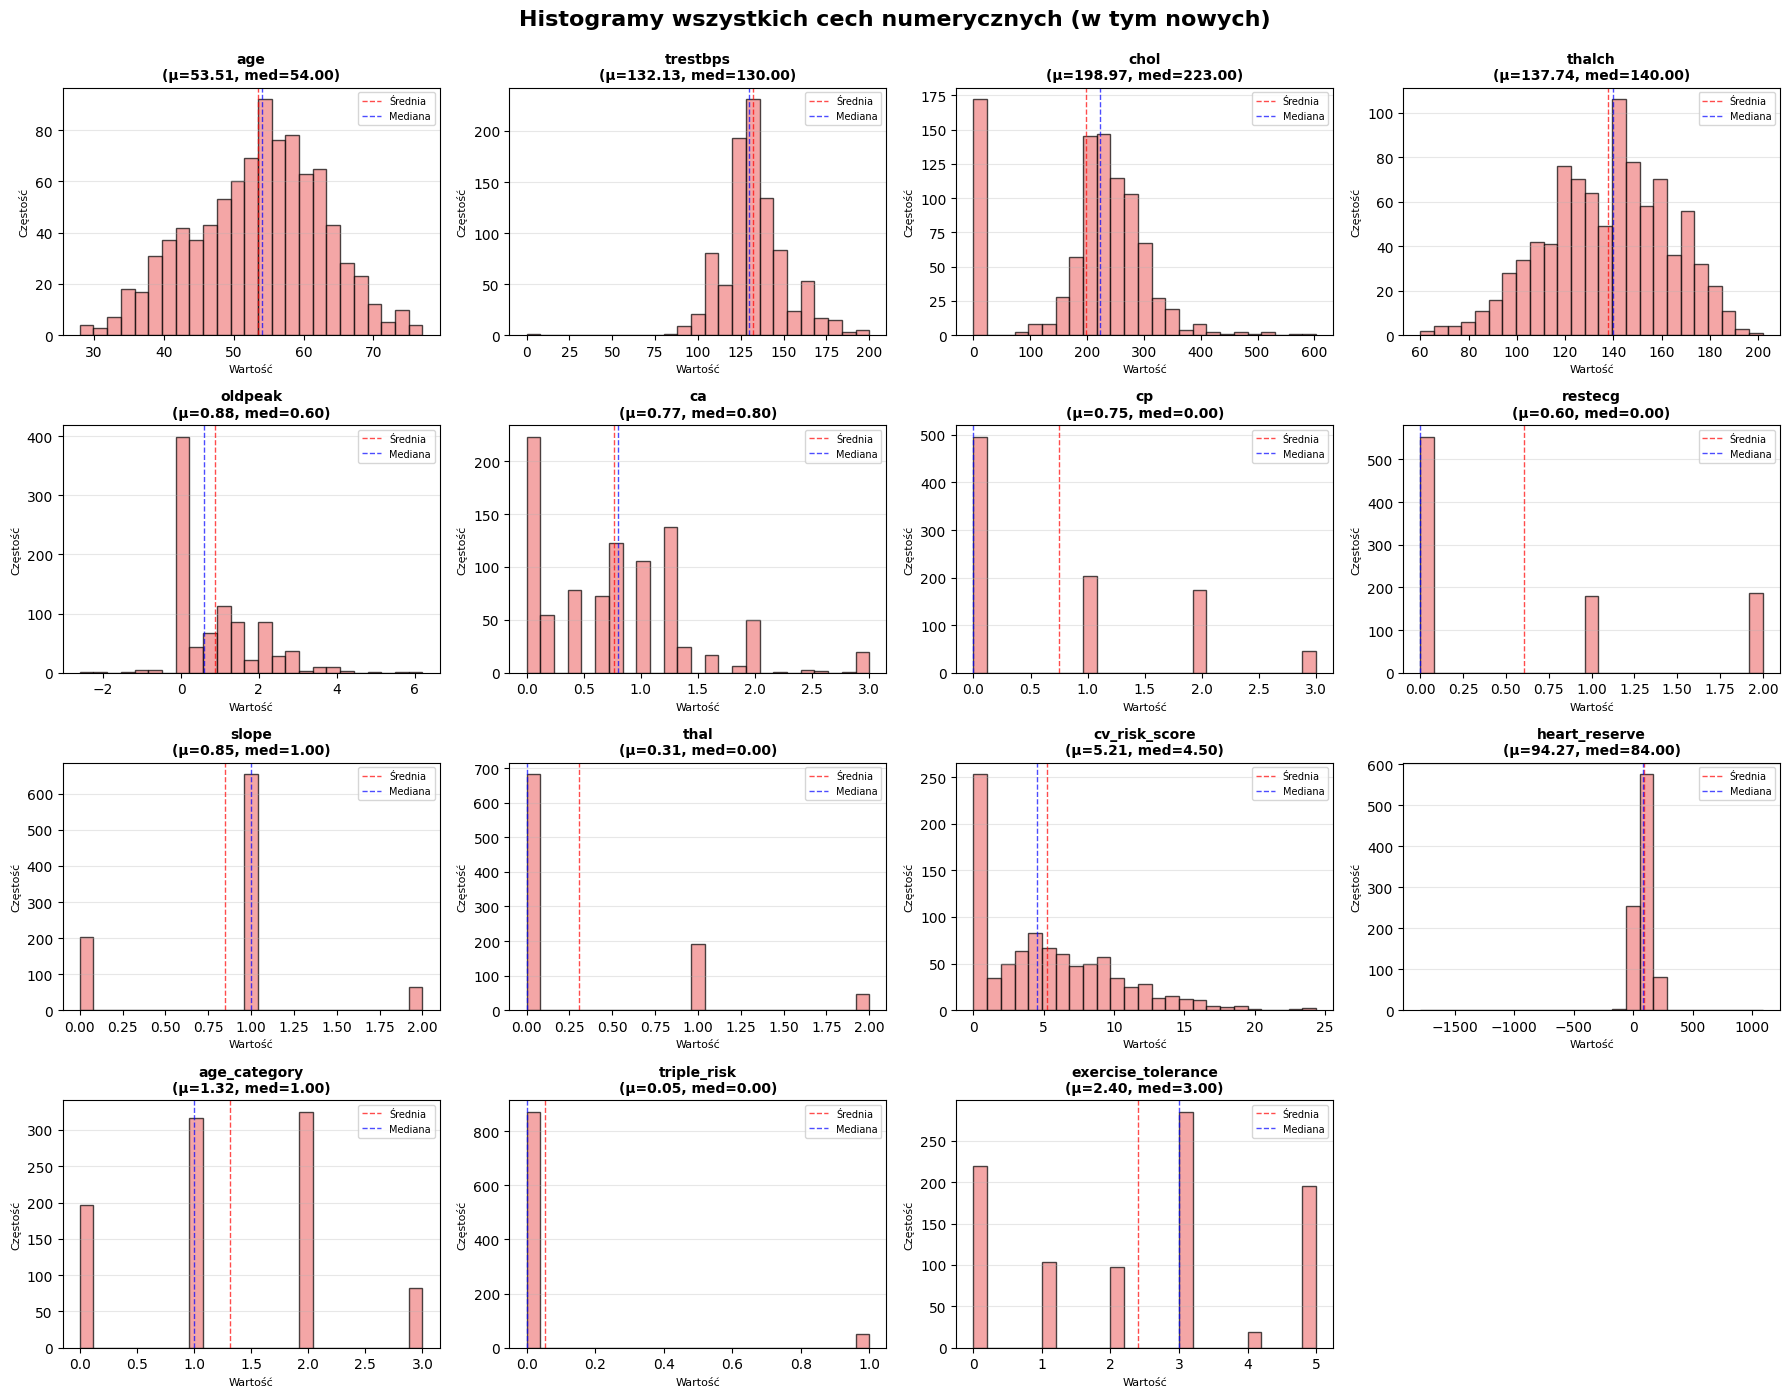

In [71]:
# HISTOGRAMY CECH NUMERYCZNYCH
# Wizualizacja rozkładu wszystkich cech numerycznych, w tym cech po ekstrakcji

import matplotlib.pyplot as plt
import numpy as np

numeric_cols = df_encoded.select_dtypes(include=['float64', 'int64']).columns.tolist()
cols_to_exclude = ['id', 'num']
numeric_cols = [col for col in numeric_cols if col not in cols_to_exclude]

# Sprawdzenie i zastąpienie wartości nieskończonych
for col in numeric_cols:
    if np.isinf(df_encoded[col]).any():
        df_encoded[col] = df_encoded[col].replace([np.inf, -np.inf], np.nan)

print(f"Liczba cech: {len(numeric_cols)}")
print(f"Cechy: {numeric_cols}\n")

# Ustawienia siatki
n_cols_plot = 4
n_rows_plot = int(np.ceil(len(numeric_cols) / n_cols_plot))

fig, axes = plt.subplots(n_rows_plot, n_cols_plot, figsize=(18, n_rows_plot * 3.5))
axes = axes.flatten()

for idx, col in enumerate(numeric_cols):
    data = df_encoded[col].dropna()

    if len(data) == 0:
        axes[idx].text(0.5, 0.5, f'{col}\n(brak danych)',
                       ha='center', va='center', fontsize=10)
        axes[idx].set_title(col, fontsize=10, fontweight='bold')
        continue

    axes[idx].hist(data, bins=25, color='lightcoral', edgecolor='black', alpha=0.7)
    mean_val, median_val = data.mean(), data.median()

    axes[idx].set_title(f'{col}\n(μ={mean_val:.2f}, med={median_val:.2f})',
                        fontsize=10, fontweight='bold')
    axes[idx].set_xlabel('Wartość', fontsize=8)
    axes[idx].set_ylabel('Częstość', fontsize=8)
    axes[idx].grid(axis='y', alpha=0.3)
    axes[idx].axvline(mean_val, color='red', linestyle='--', linewidth=1, alpha=0.7, label='Średnia')
    axes[idx].axvline(median_val, color='blue', linestyle='--', linewidth=1, alpha=0.7, label='Mediana')
    axes[idx].legend(fontsize=7, loc='upper right')

for idx in range(len(numeric_cols), len(axes)):
    fig.delaxes(axes[idx])

plt.suptitle("Histogramy wszystkich cech numerycznych (w tym nowych)", fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()


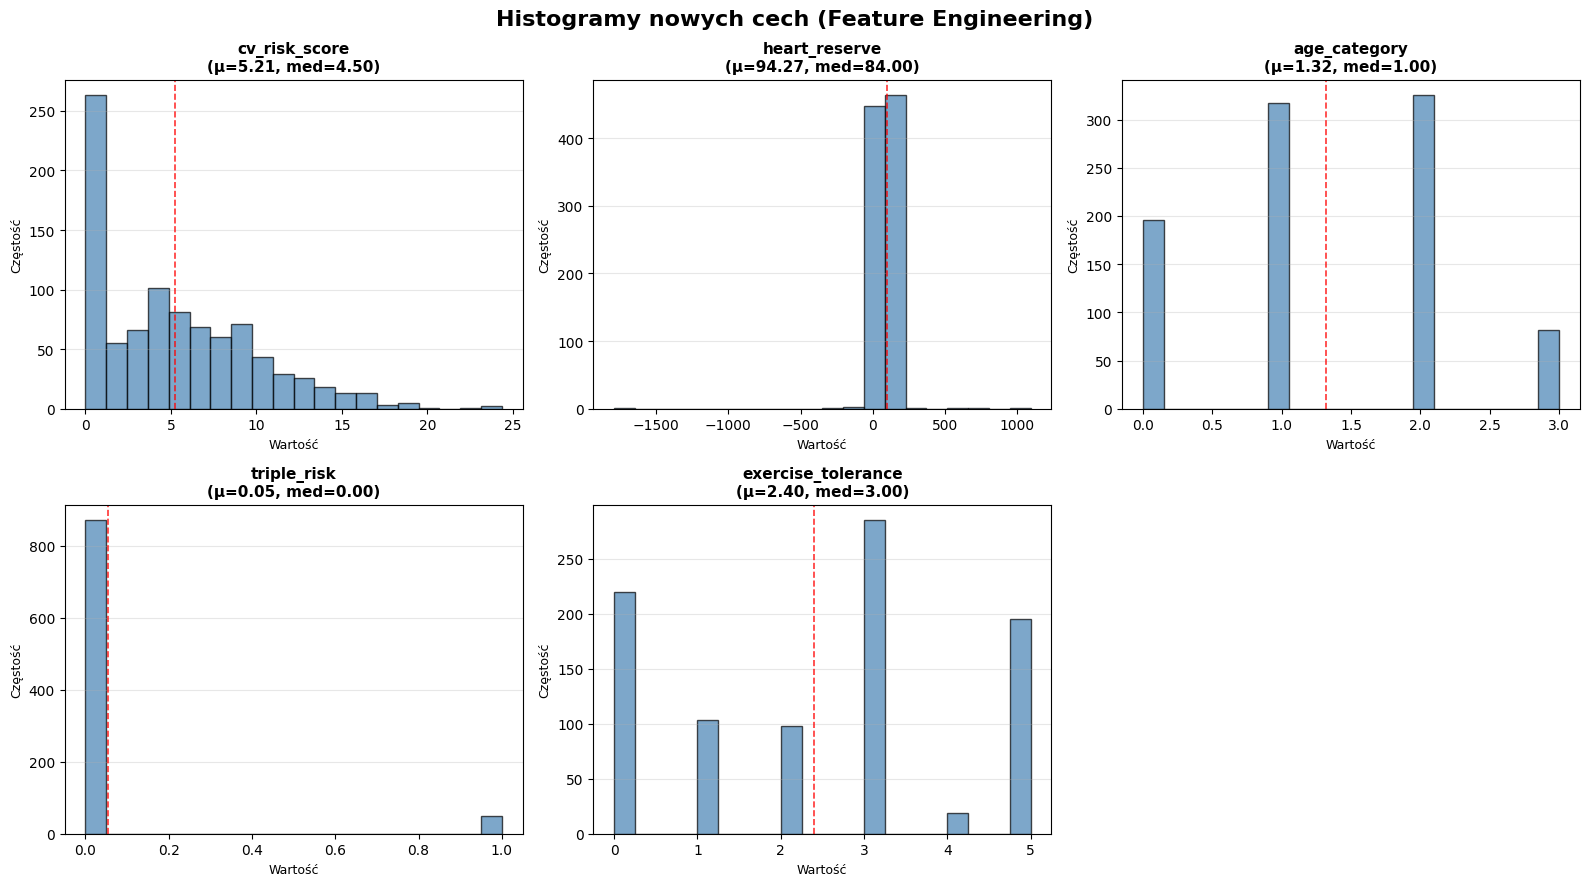


Statystyki opisowe dla nowych cech:
                    count   mean    std     min    25%   50%    75%      max
cv_risk_score       920.0   5.21   4.69     0.0   0.43   4.5    8.4    24.35
heart_reserve       918.0  94.27  90.13 -1790.0  50.00  84.0  140.0  1090.00
age_category        920.0   1.32   0.91     0.0   1.00   1.0    2.0     3.00
triple_risk         920.0   0.05   0.22     0.0   0.00   0.0    0.0     1.00
exercise_tolerance  920.0   2.40   1.79     0.0   1.00   3.0    3.0     5.00


In [72]:
# HISTOGRAMY NOWYCH CECH (Feature Engineering)
# Wizualizacja rozkładów nowych cech oraz statystyki opisowe

new_features = ['cv_risk_score', 'heart_reserve', 'age_category', 'triple_risk', 'exercise_tolerance']
existing_new_features = [f for f in new_features if f in df_encoded.columns]

if existing_new_features:
    fig, axes = plt.subplots(2, 3, figsize=(16, 9))
    axes = axes.flatten()

    for idx, col in enumerate(existing_new_features):
        data = df_encoded[col].replace([np.inf, -np.inf], np.nan).dropna()
        if len(data) == 0:
            axes[idx].text(0.5, 0.5, f'{col}\n(brak danych)',
                          ha='center', va='center', fontsize=10)
            continue

        axes[idx].hist(data, bins=20, color='steelblue', edgecolor='black', alpha=0.7)
        mean_val, median_val = data.mean(), data.median()

        axes[idx].set_title(f'{col}\n(μ={mean_val:.2f}, med={median_val:.2f})',
                            fontsize=11, fontweight='bold')
        axes[idx].set_xlabel('Wartość', fontsize=9)
        axes[idx].set_ylabel('Częstość', fontsize=9)
        axes[idx].grid(axis='y', alpha=0.3)
        axes[idx].axvline(mean_val, color='red', linestyle='--', linewidth=1.2, alpha=0.8)

    fig.delaxes(axes[-1])
    plt.suptitle("Histogramy nowych cech (Feature Engineering)", fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

    print("\nStatystyki opisowe dla nowych cech:")
    new_features_clean = df_encoded[existing_new_features].replace([np.inf, -np.inf], np.nan)
    print(new_features_clean.describe().T.round(2))


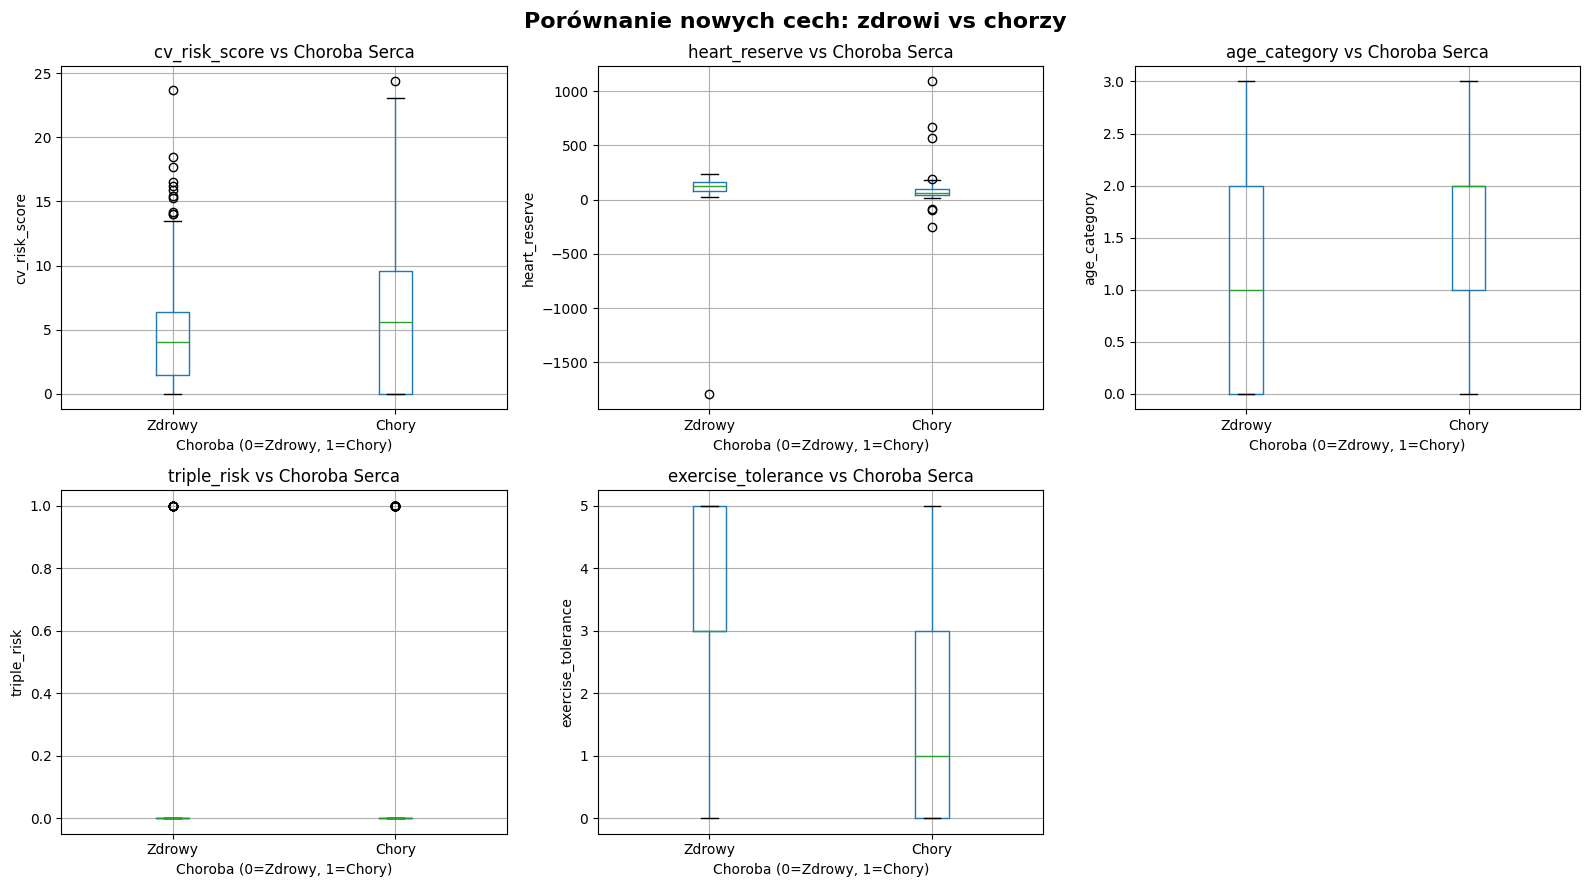


Średnie wartości nowych cech w grupach (zdrowi vs chorzy):
                cv_risk_score  heart_reserve  age_category  triple_risk  \
Zdrowi (num=0)           4.46         116.89          1.02         0.03   
Chorzy (num>0)           5.82          75.94          1.56         0.07   

                exercise_tolerance  
Zdrowi (num=0)                3.40  
Chorzy (num>0)                1.59  


In [73]:
# PORÓWNANIE NOWYCH CECH WZGLĘDEM OBECNOŚCI CHOROBY
# Boxploty oraz średnie wartości cech dla grup: zdrowi vs chorzy

if 'num' in df_encoded.columns:

    df_encoded['has_disease'] = (df_encoded['num'] > 0).astype(int)

    fig, axes = plt.subplots(2, 3, figsize=(16, 9))
    axes = axes.flatten()

    for idx, col in enumerate(existing_new_features):
        plot_data = df_encoded[[col, 'has_disease']].copy()
        plot_data[col] = plot_data[col].replace([np.inf, -np.inf], np.nan)
        plot_data = plot_data.dropna()

        if len(plot_data) == 0:
            axes[idx].text(0.5, 0.5, f'{col}\n(brak danych)',
                          ha='center', va='center', fontsize=10)
            continue

        plot_data.boxplot(column=col, by='has_disease', ax=axes[idx])
        axes[idx].set_title(f'{col} vs Choroba Serca')
        axes[idx].set_xlabel('Choroba (0=Zdrowy, 1=Chory)')
        axes[idx].set_ylabel(col)
        plt.sca(axes[idx])
        plt.xticks([1, 2], ['Zdrowy', 'Chory'])

    fig.delaxes(axes[-1])
    plt.suptitle("Porównanie nowych cech: zdrowi vs chorzy", fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

    print("\nŚrednie wartości nowych cech w grupach (zdrowi vs chorzy):")
    clean_features = df_encoded[existing_new_features].replace([np.inf, -np.inf], np.nan)
    df_temp = pd.concat([clean_features, df_encoded[['has_disease']]], axis=1)
    comparison = df_temp.groupby('has_disease')[existing_new_features].mean()
    comparison.index = ['Zdrowi (num=0)', 'Chorzy (num>0)']
    print(comparison.round(2))


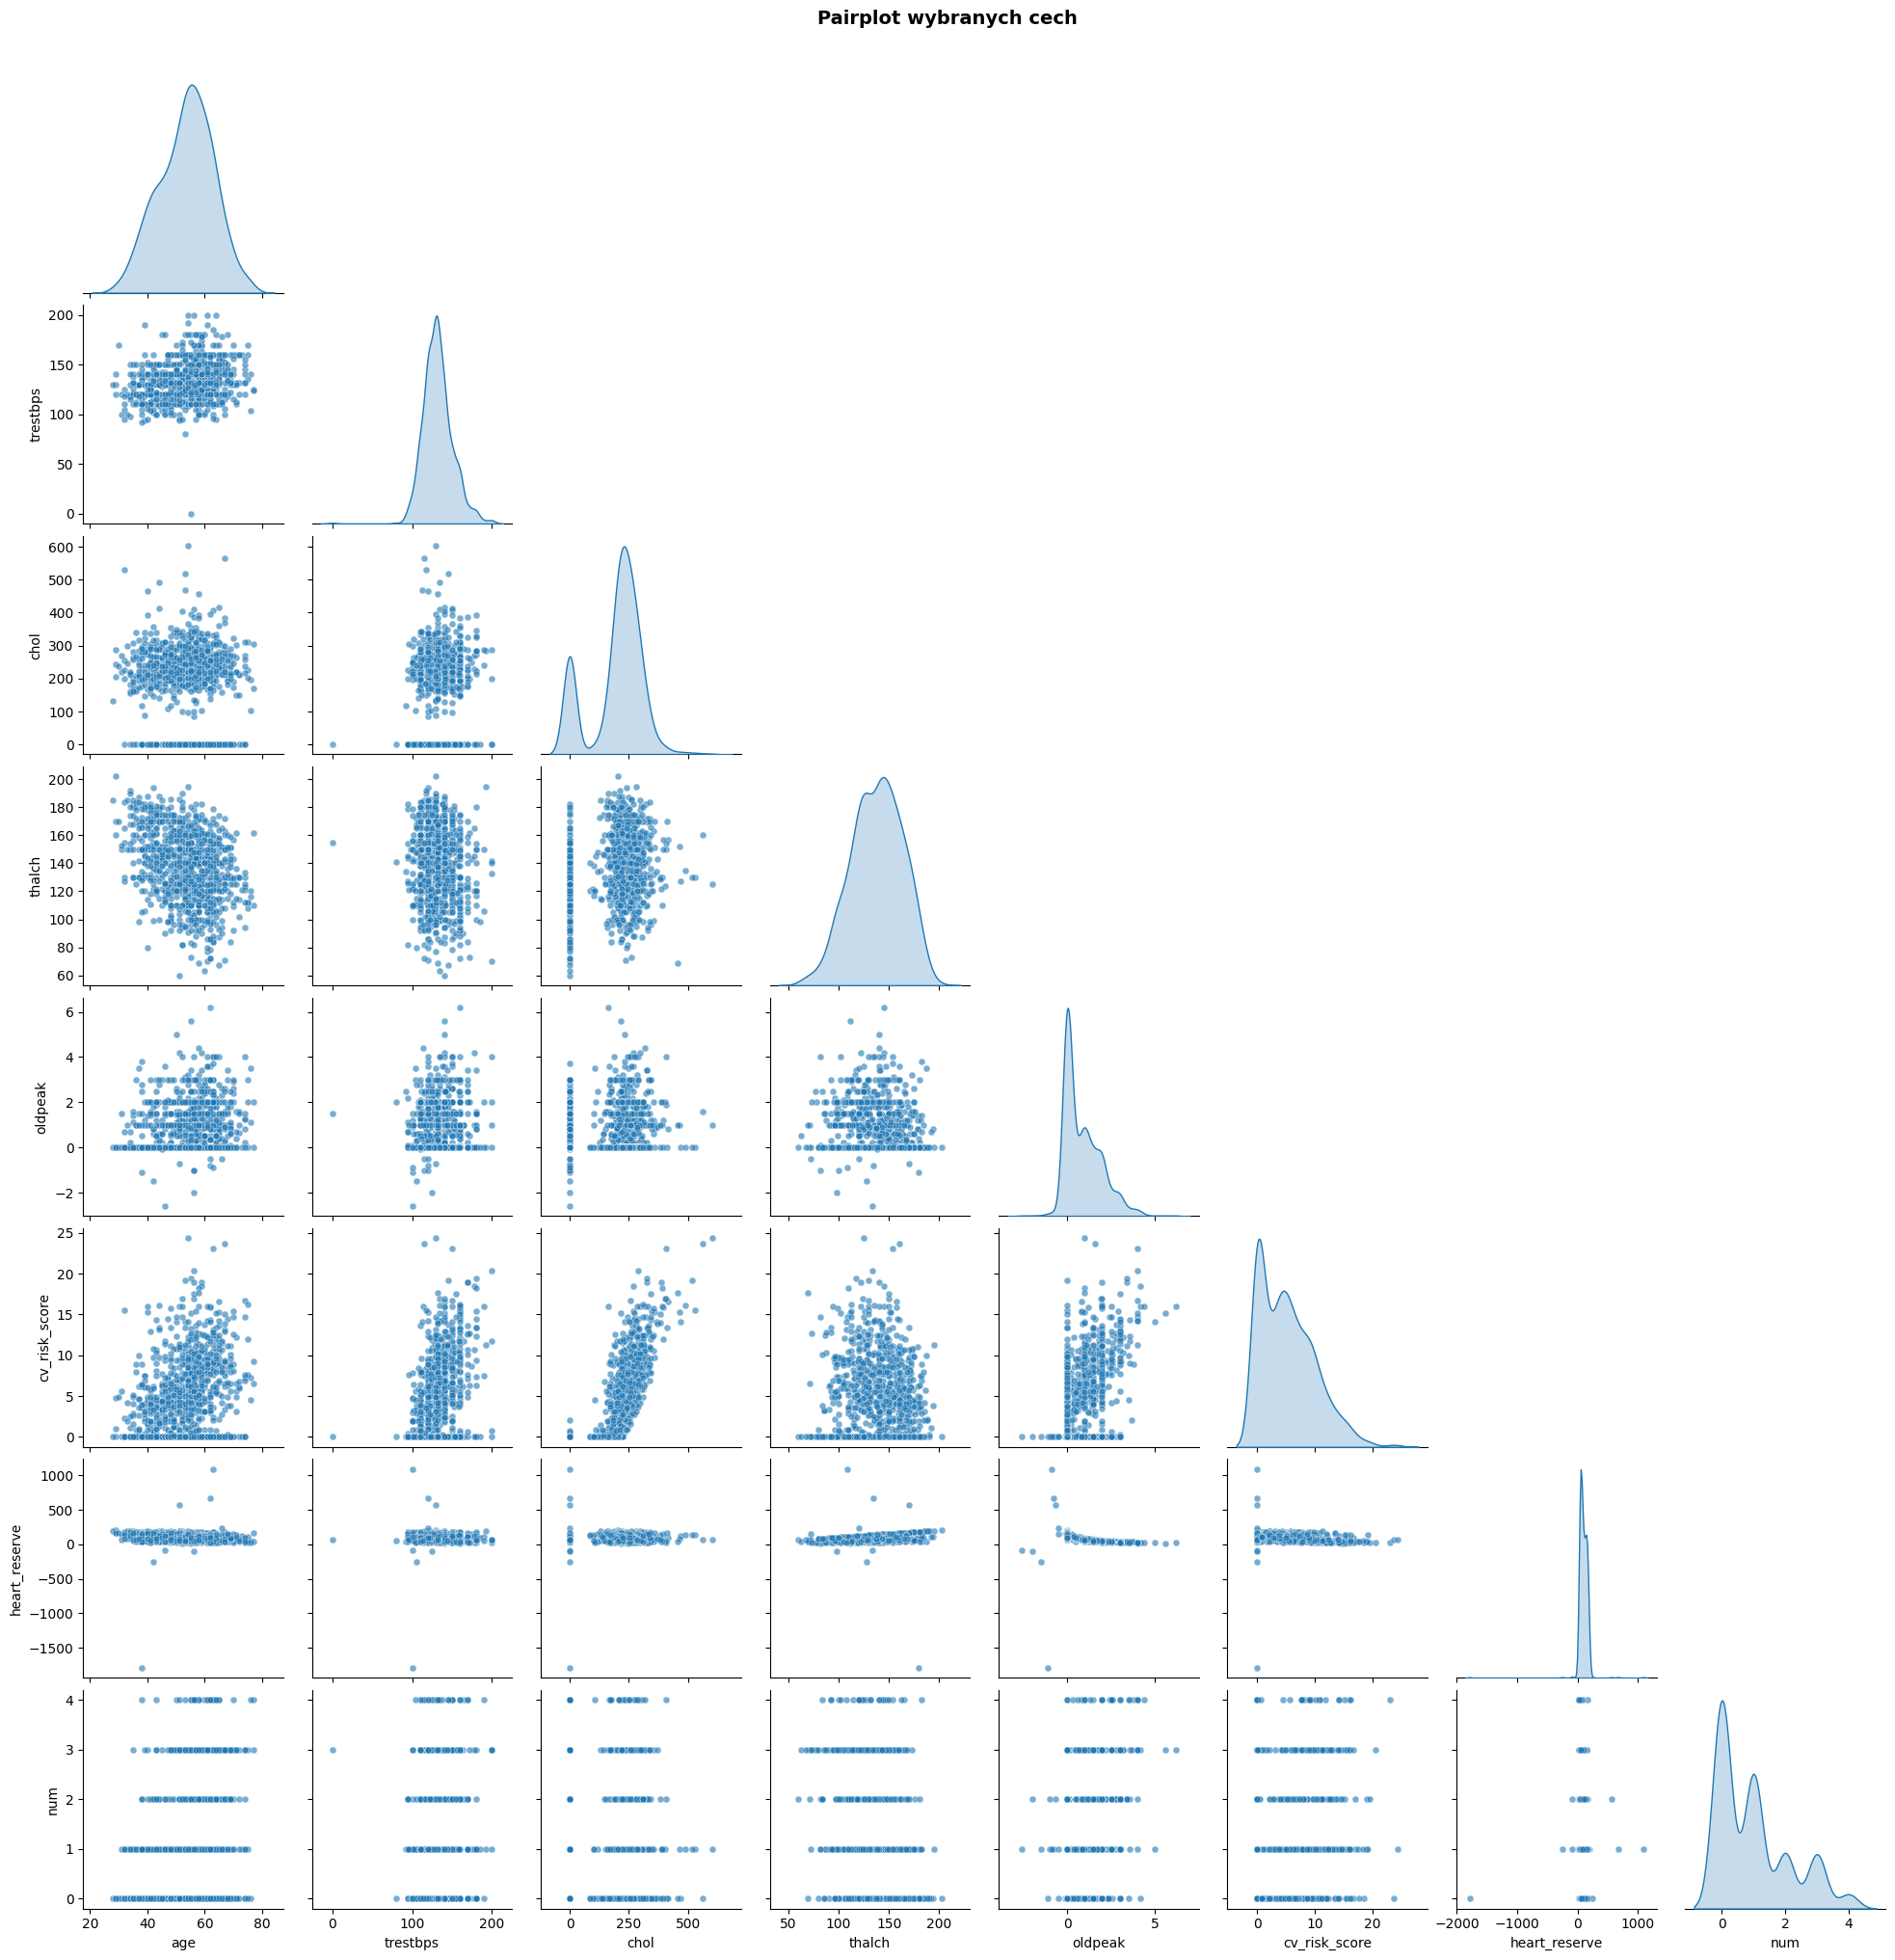

In [74]:
#Pairplot wybranych cech
import seaborn as sns
import matplotlib.pyplot as plt

# Wybór najistotniejszych cech (w tym nowe cechy z feature engineering)
selected_features = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'cv_risk_score', 'heart_reserve']
selected_features = [c for c in selected_features if c in df_encoded.columns]

if len(selected_features) <= 8:
    sns.pairplot(
        df_encoded[selected_features + (['num'] if 'num' in df_encoded.columns else [])],
        diag_kind='kde', corner=True, plot_kws={'alpha': 0.6, 's': 25}
    )
    plt.suptitle("Pairplot wybranych cech", y=1.02, fontsize=14, fontweight='bold')
    plt.show()
else:
    print("Zbyt wiele cech do pairplotu — zmniejsz liczbę w selected_features.")



=== Korelacja Pearsona (wybrane cechy) ===


,age,trestbps,chol,thalch,oldpeak,cv_risk_score,heart_reserve
age,1.00,0.24,-0.09,-0.35,0.25,0.27,-0.15
trestbps,0.24,1.00,0.09,-0.10,0.16,0.39,-0.05
chol,-0.09,0.09,1.00,0.24,0.05,0.76,0.07
thalch,-0.35,-0.10,0.24,1.00,-0.15,-0.02,0.25
oldpeak,0.25,0.16,0.05,-0.15,1.00,0.50,-0.41
cv_risk_score,0.27,0.39,0.76,-0.02,0.50,1.00,-0.19
heart_reserve,-0.15,-0.05,0.07,0.25,-0.41,-0.19,1.00


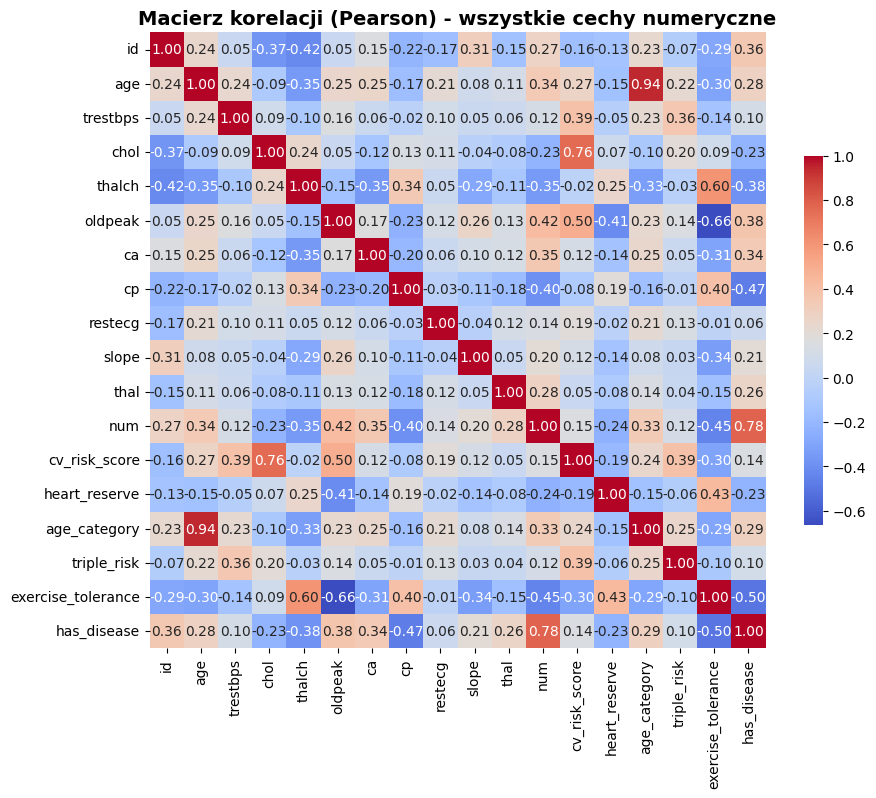

In [75]:
# Korelacja Pearsona

# Wybór tylko kolumn numerycznych
num_cols = df_encoded.select_dtypes(include=['number']).columns.tolist()
pearson_corr = df_encoded[num_cols].corr(method='pearson')

print("\n=== Korelacja Pearsona (wybrane cechy) ===")
display(pearson_corr.loc[selected_features, selected_features].round(2))

plt.figure(figsize=(10, 8))
sns.heatmap(
    pearson_corr, annot=True, fmt=".2f", cmap="coolwarm",
    square=True, cbar_kws={'shrink': .6}
)
plt.title("Macierz korelacji (Pearson) - wszystkie cechy numeryczne", fontsize=14, fontweight='bold')
plt.show()



=== Korelacja Spearmana (wybrane cechy) ===


,age,trestbps,chol,thalch,oldpeak,cv_risk_score,heart_reserve
age,1.00,0.26,-0.04,-0.33,0.28,0.25,-0.36
trestbps,0.26,1.00,0.09,-0.09,0.16,0.38,-0.16
chol,-0.04,0.09,1.00,0.19,0.05,0.81,0.05
thalch,-0.33,-0.09,0.19,1.00,-0.19,0.02,0.53
oldpeak,0.28,0.16,0.05,-0.19,1.00,0.43,-0.90
cv_risk_score,0.25,0.38,0.81,0.02,0.43,1.00,-0.35
heart_reserve,-0.36,-0.16,0.05,0.53,-0.90,-0.35,1.00


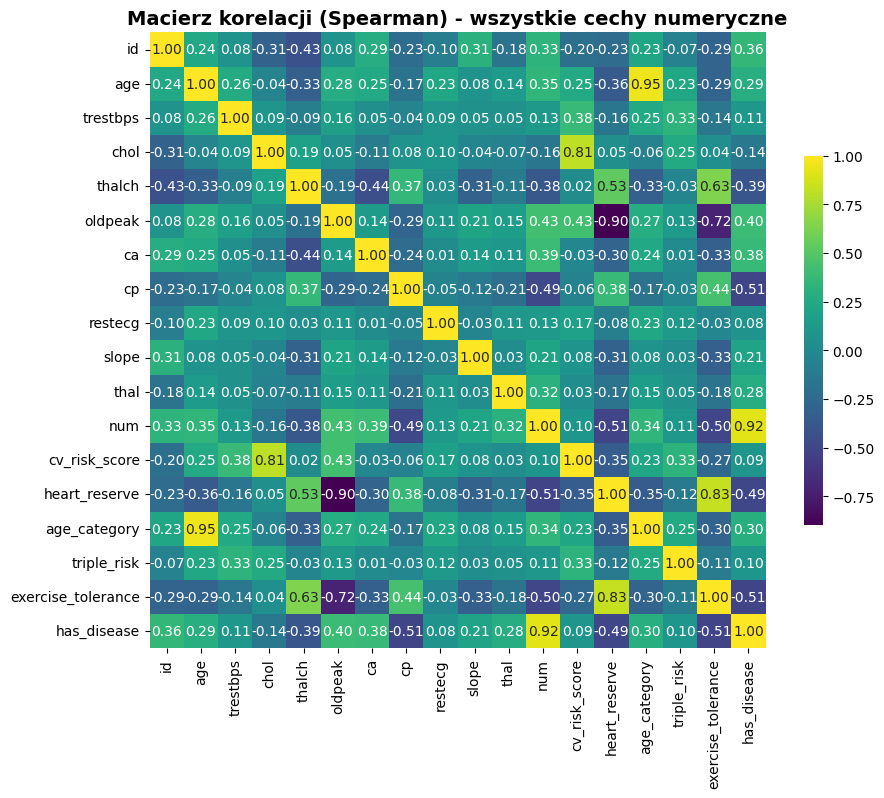

In [76]:
# Korelacja Spearmana

spearman_corr = df_encoded[num_cols].corr(method='spearman')

print("\n=== Korelacja Spearmana (wybrane cechy) ===")
display(spearman_corr.loc[selected_features, selected_features].round(2))

# Wizualizacja macierzy Spearmana
plt.figure(figsize=(10, 8))
sns.heatmap(
    spearman_corr, annot=True, fmt=".2f", cmap="viridis",
    square=True, cbar_kws={'shrink': .6}
)
plt.title("Macierz korelacji (Spearman) - wszystkie cechy numeryczne", fontsize=14, fontweight='bold')
plt.show()


In [77]:
# Identyfikacja outlierów (IQR – interquartile range)

def detect_iqr_outliers(series: pd.Series):
    """Zwraca maskę wartości odstających na podstawie 1.5 * IQR."""
    q1, q3 = series.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    return (series < lower) | (series > upper)

boxplot_cols = df_encoded.select_dtypes(include=['float64', 'int64']).columns.tolist()

outlier_summary = pd.DataFrame({
    'OutlierCount': [detect_iqr_outliers(df_encoded[c]).sum() for c in boxplot_cols],
    'OutlierPercent': [100 * detect_iqr_outliers(df_encoded[c]).mean() for c in boxplot_cols]
}, index=boxplot_cols).sort_values('OutlierPercent', ascending=False)

print("Liczba wartości odstających (top 10):")
display(outlier_summary.head(10))


Liczba wartości odstających (top 10):


,OutlierCount,OutlierPercent
slope,266,28.913043
chol,184,20.000000
triple_risk,49,5.326087
cp,46,5.000000
trestbps,28,3.043478
ca,21,2.282609
oldpeak,16,1.739130
heart_reserve,6,0.652174
cv_risk_score,4,0.434783
thalch,2,0.217391


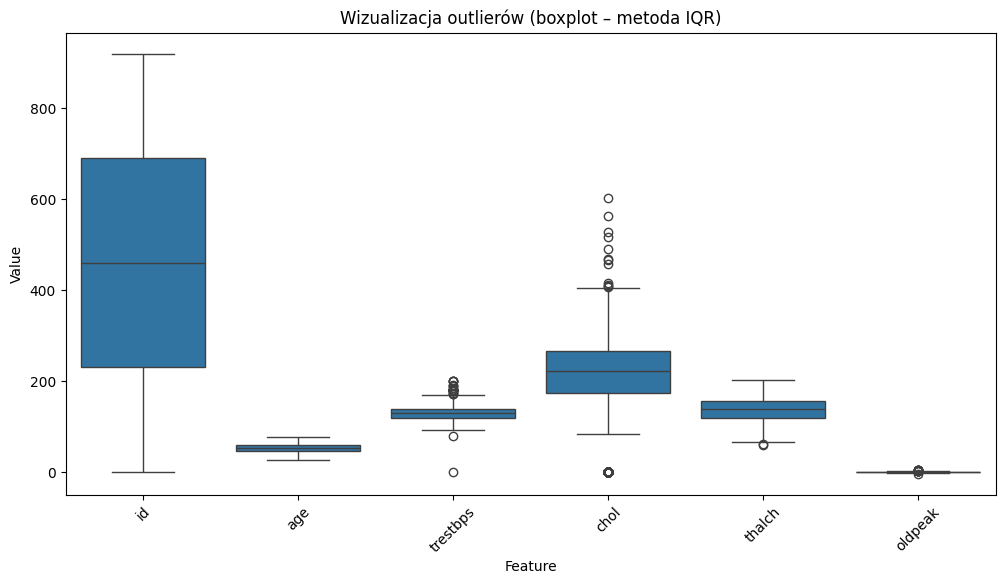

In [78]:
# Wizualizacja outlierów (boxploty)

import matplotlib.pyplot as plt
import seaborn as sns

cols_to_plot = boxplot_cols[:6]
plt.figure(figsize=(12, 6))
df_melt = df_encoded[cols_to_plot].melt(var_name='Feature', value_name='Value')
sns.boxplot(data=df_melt, x='Feature', y='Value', showfliers=True)
plt.title("Wizualizacja outlierów (boxplot – metoda IQR)")
plt.xticks(rotation=45)
plt.show()


In [79]:
# Usunięcie lub winsoryzacja outlierów


#  Usunięcie rekordów zawierających jakikolwiek outlier
# df_no_outliers = df_encoded[
#     ~pd.concat([detect_iqr_outliers(df_encoded[c]) for c in boxplot_cols], axis=1).any(axis=1)
# ]

# Alternatywnie: winsoryzacja – przycięcie wartości do granic IQR
for c in boxplot_cols:
    s = df_encoded[c]
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    df_encoded[c] = s.clip(lower, upper)

print("Winsoryzacja zakończona.")


Winsoryzacja zakończona.


In [80]:
# Sprawdzenie po usunięciu lub winsoryzacji

outlier_summary_after = pd.DataFrame({
    'OutlierCount': [detect_iqr_outliers(df_encoded[c]).sum() for c in boxplot_cols],
    'OutlierPercent': [100 * detect_iqr_outliers(df_encoded[c]).mean() for c in boxplot_cols]
}, index=boxplot_cols)

display(outlier_summary_after.head(10))
print("Łączna liczba outlierów po korekcie:",
      sum(outlier_summary_after['OutlierCount']))


,OutlierCount,OutlierPercent
id,0,0.0
age,0,0.0
trestbps,0,0.0
chol,0,0.0
thalch,0,0.0
oldpeak,0,0.0
ca,0,0.0
cp,0,0.0
restecg,0,0.0
slope,0,0.0


Łączna liczba outlierów po korekcie: 0


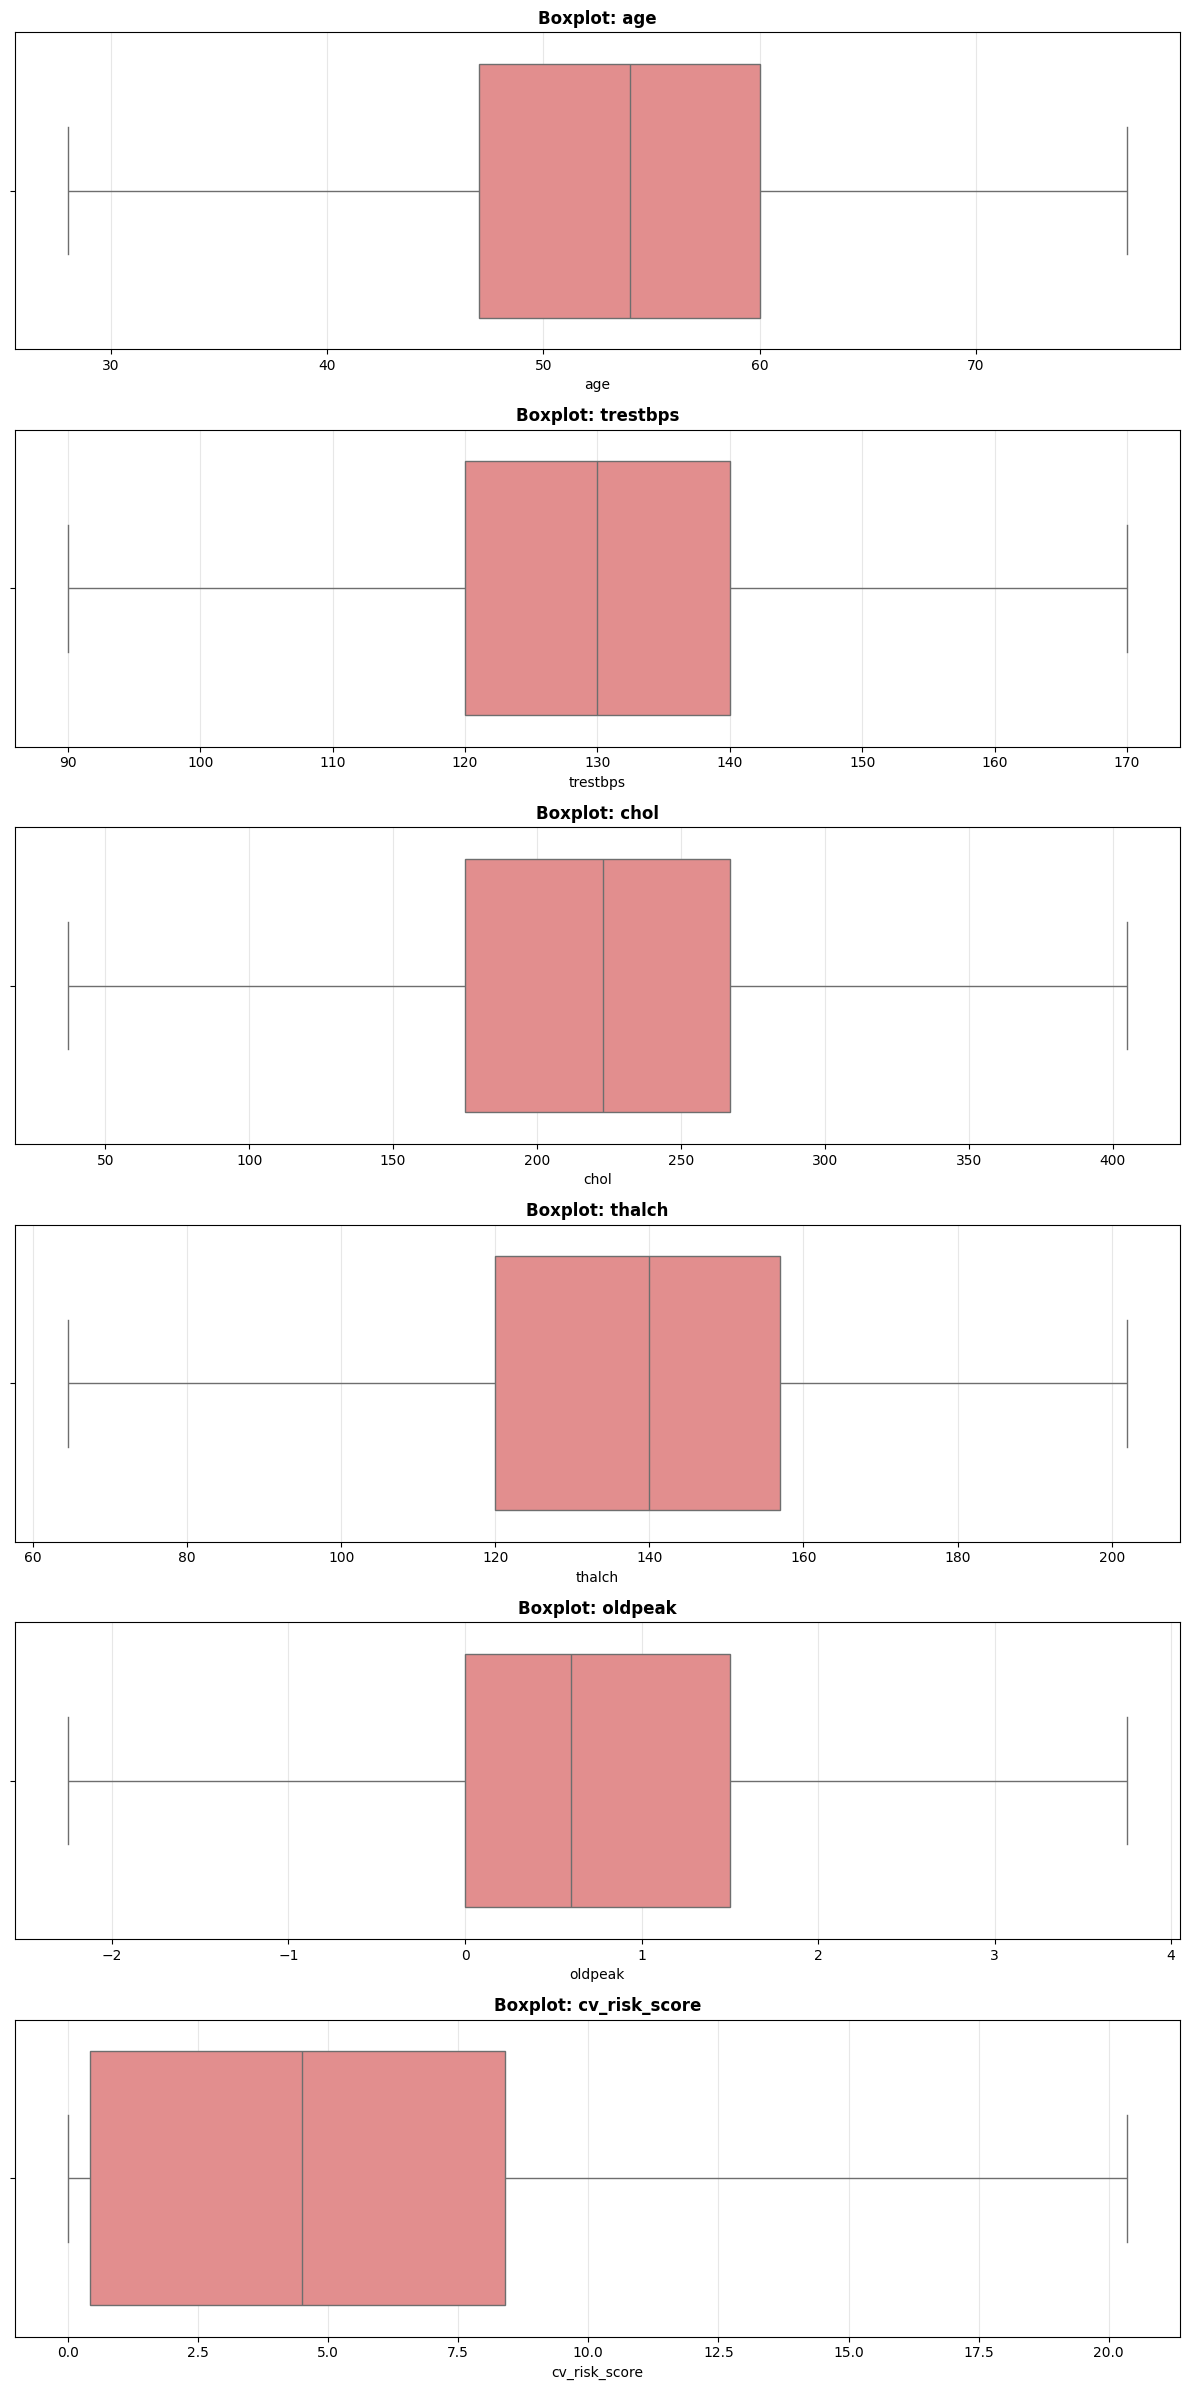

In [81]:
# Wizualizacja boxplotów dla kluczowych ceche

boxplot_cols = [c for c in ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'cv_risk_score']
                if c in df_encoded.columns]

if boxplot_cols:
    plt.figure(figsize=(12, 4 * len(boxplot_cols)))
    for i, col in enumerate(boxplot_cols, 1):
        plt.subplot(len(boxplot_cols), 1, i)
        sns.boxplot(x=df_encoded[col].replace([np.inf, -np.inf], np.nan), color='lightcoral')
        plt.title(f'Boxplot: {col}', fontsize=12, fontweight='bold')
        plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()


In [82]:
#!pip install pycaret[full]

In [83]:
# PyCaret - automatyczne przetwarzanie i imputacja
# Uwaga: zainstaluj pycaret w środowisku przed uruchomieniem:
# !pip install pycaret[full]

#from pycaret.classification import setup as pyc_setup, finalize_model, get_config
#import pandas as pd

# Przygotuj kopię danych do imputacji (zachowaj oryginał)
#df_py = df_encoded.copy()

# PyCaret expects target column name; upewnij się, że 'num' jest targetem i typ int
#df_py['num'] = df_py['num'].astype(int)

# uruchom setup z imputacją 'simple' lub 'knn' — pycaret automatycznie obsłuży brakujące
#s = pyc_setup(data=df_py, target='num', silent=True, html=False, session_id=42,
              #imputation_type='simple')  # lub 'iterative' / 'knn' zależnie od wersji PyCaret

# Po setup pycaret przeprowadza preprocessing — odczytaj przetworzone dane:
#processed = get_config('X')  # features po preprocessing
#processed_y = get_config('y')

# Połącz z targetem (jeśli chcesz plik z imputacją)
#df_py_imputed = pd.concat([processed.reset_index(drop=True), processed_y.reset_index(drop=True)], axis=1)
#print("PyCaret finished. Shape:", df_py_imputed.shape)


#Imputacja Alternatywna - IterativeImputer (PyCaret nie chce działać, a downgrade wyrzuca więcej innych błędów)

In [84]:
# Sprawdź PRZED skalowaniem:
print(df_encoded['slope'].value_counts())
print(df_encoded['triple_risk'].value_counts())

slope
1.0    920
Name: count, dtype: int64
triple_risk
0    920
Name: count, dtype: int64


In [85]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

df_iter = df_encoded.copy()

#tylko kolumny numeryczne do imputacji (target osobno)
num_cols_for_impute = df_iter.select_dtypes(include=['float64','int64']).columns.tolist()
exclude = ['id']
num_cols_for_impute = [c for c in num_cols_for_impute if c not in exclude]

iter_imp = IterativeImputer(random_state=0, max_iter=10, sample_posterior=False)
df_iter_num = pd.DataFrame(iter_imp.fit_transform(df_iter[num_cols_for_impute]), columns=num_cols_for_impute, index=df_iter.index)

# Zastąp numeryczne kolumny imputowanymi
df_iter.loc[:, num_cols_for_impute] = df_iter_num
print("IterativeImputer done. Any NaNs left:", df_iter[num_cols_for_impute].isna().sum().sum())


IterativeImputer done. Any NaNs left: 0


Liczba cech: 16
Cechy: ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca', 'cp', 'restecg', 'slope', 'thal', 'cv_risk_score', 'heart_reserve', 'age_category', 'triple_risk', 'exercise_tolerance', 'has_disease']



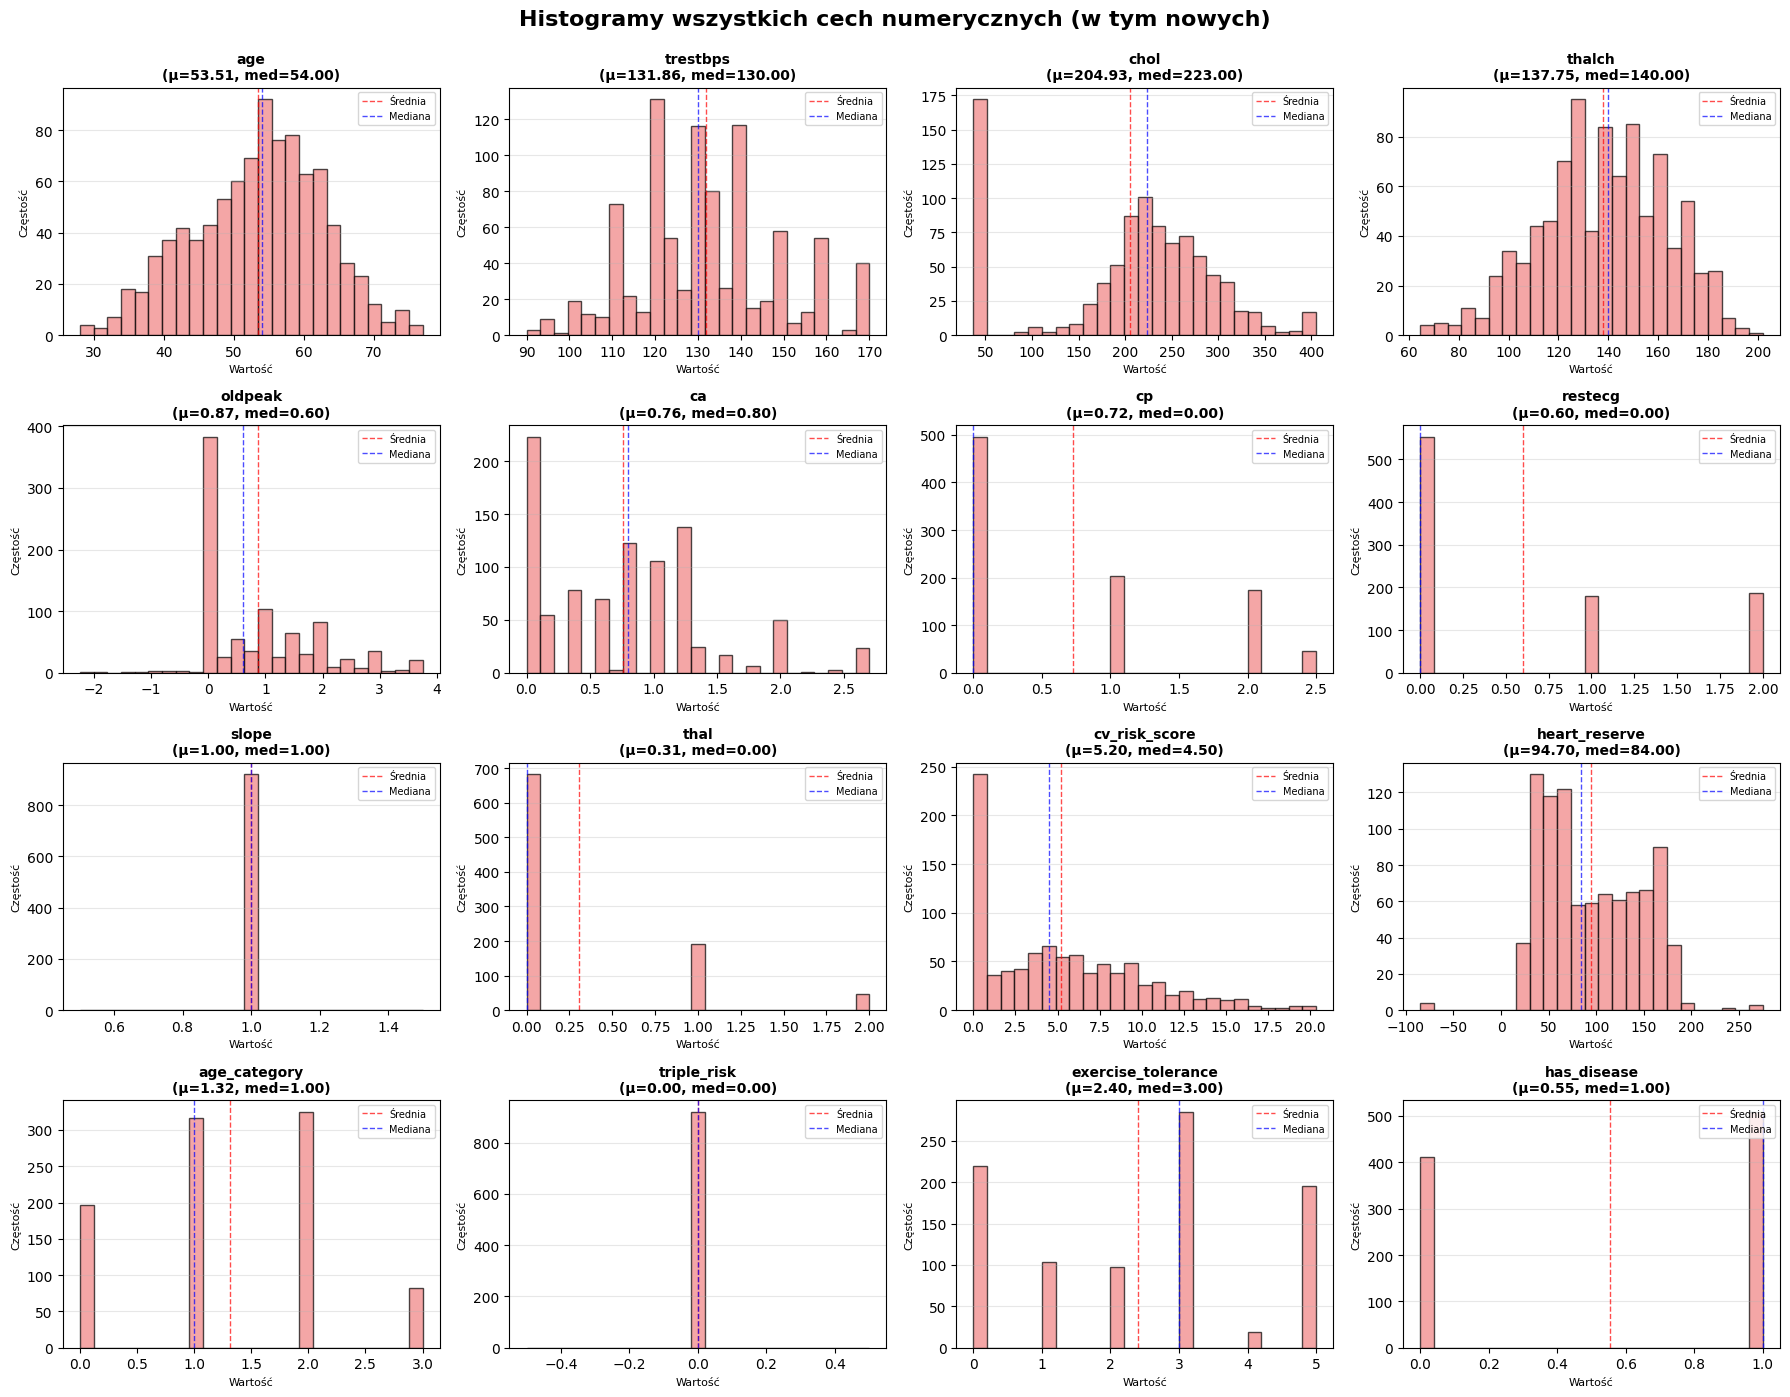

In [86]:
# HISTOGRAMY CECH NUMERYCZNYCH
# Wizualizacja rozkładu wszystkich cech numerycznych, w tym cech po ekstrakcji

import matplotlib.pyplot as plt
import numpy as np

numeric_cols = df_encoded.select_dtypes(include=['float64', 'int64']).columns.tolist()
cols_to_exclude = ['id', 'num']
numeric_cols = [col for col in numeric_cols if col not in cols_to_exclude]

# Sprawdzenie i zastąpienie wartości nieskończonych
for col in numeric_cols:
    if np.isinf(df_encoded[col]).any():
        df_encoded[col] = df_encoded[col].replace([np.inf, -np.inf], np.nan)

print(f"Liczba cech: {len(numeric_cols)}")
print(f"Cechy: {numeric_cols}\n")

# Ustawienia siatki
n_cols_plot = 4
n_rows_plot = int(np.ceil(len(numeric_cols) / n_cols_plot))

fig, axes = plt.subplots(n_rows_plot, n_cols_plot, figsize=(18, n_rows_plot * 3.5))
axes = axes.flatten()

for idx, col in enumerate(numeric_cols):
    data = df_encoded[col].dropna()

    if len(data) == 0:
        axes[idx].text(0.5, 0.5, f'{col}\n(brak danych)',
                       ha='center', va='center', fontsize=10)
        axes[idx].set_title(col, fontsize=10, fontweight='bold')
        continue

    axes[idx].hist(data, bins=25, color='lightcoral', edgecolor='black', alpha=0.7)
    mean_val, median_val = data.mean(), data.median()

    axes[idx].set_title(f'{col}\n(μ={mean_val:.2f}, med={median_val:.2f})',
                        fontsize=10, fontweight='bold')
    axes[idx].set_xlabel('Wartość', fontsize=8)
    axes[idx].set_ylabel('Częstość', fontsize=8)
    axes[idx].grid(axis='y', alpha=0.3)
    axes[idx].axvline(mean_val, color='red', linestyle='--', linewidth=1, alpha=0.7, label='Średnia')
    axes[idx].axvline(median_val, color='blue', linestyle='--', linewidth=1, alpha=0.7, label='Mediana')
    axes[idx].legend(fontsize=7, loc='upper right')

for idx in range(len(numeric_cols), len(axes)):
    fig.delaxes(axes[idx])

plt.suptitle("Histogramy wszystkich cech numerycznych (w tym nowych)", fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()


#Przygotowanie 4 metod imputacji + 2 skalowania → 8 datasetów

4 metody imputacji:

  *mean (SimpleImputer(strategy='mean')) — łatwy

  *median (SimpleImputer(strategy='median')) — łatwy

  *KNNImputer (n_neighbors=5) — trudniejszy/zaawansowany

  *IterativeImputer (lub PyCaret jeśli preferujesz) — automatyczny/trudniejszy

Dla każdego utworzymy dwie wersje: MinMax (manual) i Standard (Z-score manual)

In [87]:
imputers = {
    'mean': SimpleImputer(strategy='mean'),
    'median': SimpleImputer(strategy='median'),
    'most_frequent': SimpleImputer(strategy='most_frequent'),
    'constant0': SimpleImputer(strategy='constant', fill_value=0)
}

datasets = {}
for imp_name, imp in imputers.items():
    df_tmp = df_encoded.copy()
    df_tmp_num = pd.DataFrame(imp.fit_transform(df_tmp[num_cols]), columns=num_cols, index=df_tmp.index)
    df_tmp.loc[:, num_cols] = df_tmp_num

    # MinMax
    df_mm = df_tmp.copy()
    for c in num_cols:
        arr = df_mm[c].astype(float)
        min_v = arr.min(); max_v = arr.max()
        df_mm[c] = 0.0 if max_v - min_v == 0 else (arr - min_v) / (max_v - min_v)
    datasets[f'{imp_name}_minmax'] = df_mm

    # Z-score
    df_z = df_tmp.copy()
    for c in num_cols:
        arr = df_z[c].astype(float)
        mean_v = arr.mean(); std_v = arr.std(ddof=0)
        df_z[c] = 0.0 if std_v == 0 else (arr - mean_v) / std_v
    datasets[f'{imp_name}_zscore'] = df_z

print("Stworzono dokładnie 8 datasetów:")
for k in sorted(datasets.keys()):
    print(" -", k, "shape:", datasets[k].shape)

Stworzono dokładnie 8 datasetów:
 - constant0_minmax shape: (920, 25)
 - constant0_zscore shape: (920, 25)
 - mean_minmax shape: (920, 25)
 - mean_zscore shape: (920, 25)
 - median_minmax shape: (920, 25)
 - median_zscore shape: (920, 25)
 - most_frequent_minmax shape: (920, 25)
 - most_frequent_zscore shape: (920, 25)


In [88]:
for name, df_d in datasets.items():
    numcols = [c for c in df_d.select_dtypes(include=['float64','int64']).columns if c not in ('id',)]
    nan_count = df_d[numcols].isna().sum().sum()
    print(name, "| shape:", df_d.shape, "| NaNs:", nan_count)

    if 'num' in df_d.columns:
        corr_matrix = df_d[numcols + ['num']].corr()
        if 'num' in corr_matrix.columns:
            corr_with_target = corr_matrix['num'].drop('num')
            if isinstance(corr_with_target, pd.DataFrame):

                corr_with_target = corr_with_target.iloc[:,0]
            corr_with_target = corr_with_target.abs().sort_values(ascending=False).head(5).round(2)
            print(" top corrs with num:")
            print(corr_with_target)
        else:
            print("⚠️ Kolumna 'num' nieznaleziona w macierzy korelacji.")
    else:
        print("⚠️ Brak kolumny 'num' w tym zbiorze.")
    print("-"*50)


mean_minmax | shape: (920, 25) | NaNs: 0
 top corrs with num:
has_disease           0.78
heart_reserve         0.46
exercise_tolerance    0.45
oldpeak               0.42
cp                    0.42
Name: num, dtype: float64
--------------------------------------------------
mean_zscore | shape: (920, 25) | NaNs: 0
 top corrs with num:
has_disease           0.78
heart_reserve         0.46
exercise_tolerance    0.45
oldpeak               0.42
cp                    0.42
Name: num, dtype: float64
--------------------------------------------------
median_minmax | shape: (920, 25) | NaNs: 0
 top corrs with num:
has_disease           0.78
heart_reserve         0.46
exercise_tolerance    0.45
oldpeak               0.42
cp                    0.42
Name: num, dtype: float64
--------------------------------------------------
median_zscore | shape: (920, 25) | NaNs: 0
 top corrs with num:
has_disease           0.78
heart_reserve         0.46
exercise_tolerance    0.45
oldpeak               0.42
cp  

In [89]:
display(datasets['mean_minmax'].describe().T)

,count,mean,std,min,25%,50%,75%,max
id,920.0,0.500000,0.289146,0.0,0.250000,0.500000,0.750000,1.0
age,920.0,0.520630,0.192341,0.0,0.387755,0.530612,0.653061,1.0
trestbps,920.0,0.523272,0.211450,0.0,0.375000,0.500000,0.625000,1.0
chol,920.0,0.456330,0.256819,0.0,0.375000,0.505435,0.625000,1.0
thalch,920.0,0.532716,0.184295,0.0,0.403636,0.549091,0.672727,1.0
oldpeak,920.0,0.519586,0.171175,0.0,0.375000,0.475000,0.625000,1.0
ca,920.0,0.281453,0.241935,0.0,0.074074,0.296296,0.444444,1.0
cp,920.0,0.290000,0.350078,0.0,0.000000,0.000000,0.400000,1.0
restecg,920.0,0.301630,0.402721,0.0,0.000000,0.000000,0.500000,1.0
slope,920.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0


#Czesc 2 - Trening modeli

## 6. MODELOWANIE

### 6.1 Strategia modelowania

Projekt wykorzystuje:
- **8 wariantów danych**: 4 metody imputacji × 2 metody skalowania
- **8 algorytmów**: 4 bazowe + 2 zaawansowane + 2 zespołowe
- **Walidację**: train/test split + 5-fold cross-validation

### 6.2 Wybór metryk

Dla klasyfikacji chorób serca kluczowe są:
- **Recall (Sensitivity)**: minimalizacja false negatives - nie przeoczyć choroby
- **Precision**: minimalizacja false positives - unikać niepotrzebnych badań
- **F1-Score**: balans między precision i recall
- **ROC AUC**: ogólna zdolność dyskryminacyjna modelu

In [90]:
# =============================================================================
# PODZIAŁ DANYCH NA TRAIN/TEST DLA WSZYSTKICH 8 DATASETÓW
# =============================================================================

import numpy as np
import pandas as pd
from collections import Counter

def manual_train_test_split(X, y, test_size=0.2, random_state=None, stratify=True):

    if random_state is not None:
        np.random.seed(random_state)

    n = len(X)
    indices = np.arange(n)

    if stratify:
        unique_classes = np.unique(y)
        train_idx, test_idx = [], []

        for cls in unique_classes:
            cls_indices = indices[y == cls]
            n_test_cls = int(len(cls_indices) * test_size)

            shuffled = np.random.permutation(cls_indices)
            test_idx.extend(shuffled[:n_test_cls])
            train_idx.extend(shuffled[n_test_cls:])

        train_idx = np.array(train_idx)
        test_idx = np.array(test_idx)
    else:
        shuffled = np.random.permutation(indices)
        n_test = int(n * test_size)
        test_idx = shuffled[:n_test]
        train_idx = shuffled[n_test:]

    if isinstance(X, pd.DataFrame):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    else:
        X_train, X_test = X[train_idx], X[test_idx]

    if isinstance(y, pd.Series):
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    else:
        y_train, y_test = y[train_idx], y[test_idx]

    return X_train, X_test, y_train, y_test

#wszystkie 8 datasetów
prepared_datasets = {}

for dataset_name, df in datasets.items():
    df_prep = df.copy()

    # Przywrócenie dyskretnego targetu
    if 'has_disease' in df_prep.columns:
        df_prep['has_disease'] = (df_prep['has_disease'] > 0).astype(int)
    elif 'num' in df_prep.columns:
        df_prep['has_disease'] = (df_prep['num'] > 0).astype(int)

    cols_to_drop = ['num', 'dataset_origin', 'id','slope','triple_risk']
    df_prep = df_prep.drop(columns=[c for c in cols_to_drop if c in df_prep.columns], errors='ignore')

    if 'has_disease' not in df_prep.columns:
        if 'num' in df.columns:
            df_prep['has_disease'] = (df['num'] > 0).astype(int)

    target_col = 'has_disease'
    feature_cols = [c for c in df_prep.columns if c != target_col]

    X = df_prep[feature_cols].copy()
    y = df_prep[target_col].copy()

    X_train, X_test, y_train, y_test = manual_train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=True
    )

    prepared_datasets[dataset_name] = {
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'feature_cols': feature_cols
    }

print("8 datasetów z podziałem train/test:")
for name, data in prepared_datasets.items():
    print(f"\n{name}:")
    print(f"  Train: {len(data['X_train'])} samples, {len(data['feature_cols'])} features")
    print(f"  Test: {len(data['X_test'])} samples")
    print(f"  Train class balance: {Counter(data['y_train'])}")
    print(f"  Test class balance: {Counter(data['y_test'])}")

8 datasetów z podziałem train/test:

mean_minmax:
  Train: 737 samples, 19 features
  Test: 183 samples
  Train class balance: Counter({1: 408, 0: 329})
  Test class balance: Counter({1: 101, 0: 82})

mean_zscore:
  Train: 737 samples, 19 features
  Test: 183 samples
  Train class balance: Counter({1: 408, 0: 329})
  Test class balance: Counter({1: 101, 0: 82})

median_minmax:
  Train: 737 samples, 19 features
  Test: 183 samples
  Train class balance: Counter({1: 408, 0: 329})
  Test class balance: Counter({1: 101, 0: 82})

median_zscore:
  Train: 737 samples, 19 features
  Test: 183 samples
  Train class balance: Counter({1: 408, 0: 329})
  Test class balance: Counter({1: 101, 0: 82})

most_frequent_minmax:
  Train: 737 samples, 19 features
  Test: 183 samples
  Train class balance: Counter({1: 408, 0: 329})
  Test class balance: Counter({1: 101, 0: 82})

most_frequent_zscore:
  Train: 737 samples, 19 features
  Test: 183 samples
  Train class balance: Counter({1: 408, 0: 329})
  Tes

In [91]:
# =============================================================================
# IMPLEMENTACJA METRYK OCENY (RĘCZNA)
# =============================================================================

def manual_confusion_matrix(y_true, y_pred):
    """Ręczna implementacja macierzy pomyłek."""
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))

    return np.array([[tn, fp], [fn, tp]])

def manual_accuracy(y_true, y_pred):
    """Ręczna implementacja accuracy."""
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.sum(y_true == y_pred) / len(y_true)

def manual_precision(y_true, y_pred):
    """Ręczna implementacja precision."""
    cm = manual_confusion_matrix(y_true, y_pred)
    tp, fp = cm[1, 1], cm[0, 1]
    return tp / (tp + fp) if (tp + fp) > 0 else 0.0

def manual_recall(y_true, y_pred):
    """Ręczna implementacja recall (sensitivity)."""
    cm = manual_confusion_matrix(y_true, y_pred)
    tp, fn = cm[1, 1], cm[1, 0]
    return tp / (tp + fn) if (tp + fn) > 0 else 0.0

def manual_f1_score(y_true, y_pred):
    """Ręczna implementacja F1-score."""
    prec = manual_precision(y_true, y_pred)
    rec = manual_recall(y_true, y_pred)
    return 2 * (prec * rec) / (prec + rec) if (prec + rec) > 0 else 0.0

def manual_specificity(y_true, y_pred):
    """Ręczna implementacja specificity."""
    cm = manual_confusion_matrix(y_true, y_pred)
    tn, fp = cm[0, 0], cm[0, 1]
    return tn / (tn + fp) if (tn + fp) > 0 else 0.0

def manual_roc_auc(y_true, y_proba):
    """Ręczna implementacja ROC AUC."""
    y_true = np.array(y_true)
    y_proba = np.array(y_proba)

    desc_score_indices = np.argsort(y_proba)[::-1]
    y_true_sorted = y_true[desc_score_indices]

    tpr_list, fpr_list = [0], [0]
    tp = fp = 0
    n_pos = np.sum(y_true == 1)
    n_neg = np.sum(y_true == 0)

    for label in y_true_sorted:
        if label == 1:
            tp += 1
        else:
            fp += 1
        tpr = tp / n_pos if n_pos > 0 else 0
        fpr = fp / n_neg if n_neg > 0 else 0
        tpr_list.append(tpr)
        fpr_list.append(fpr)

    auc = 0
    for i in range(1, len(fpr_list)):
        auc += (fpr_list[i] - fpr_list[i-1]) * (tpr_list[i] + tpr_list[i-1]) / 2

    return auc

def evaluate_model(y_true, y_pred, y_proba=None):
    """Kompleksowa ocena modelu."""
    results = {
        'Accuracy': manual_accuracy(y_true, y_pred),
        'Precision': manual_precision(y_true, y_pred),
        'Recall': manual_recall(y_true, y_pred),
        'F1-Score': manual_f1_score(y_true, y_pred),
        'Specificity': manual_specificity(y_true, y_pred)
    }

    if y_proba is not None:
        results['ROC AUC'] = manual_roc_auc(y_true, y_proba)

    return results

In [92]:
# =============================================================================
# TRENING MODELI NA WSZYSTKICH 8 DATASETACH - SCIKIT-LEARN
# =============================================================================

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

models_sklearn = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(max_depth=10, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42)
}

all_results = {}

for dataset_name, data in prepared_datasets.items():
    print(f"\n{'='*80}")
    print(f"DATASET: {dataset_name}")
    print(f"{'='*80}")

    X_train = data['X_train']
    X_test = data['X_test']
    y_train = data['y_train']
    y_test = data['y_test']

    dataset_results = {}

    for model_name, model in models_sklearn.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

        dataset_results[model_name] = evaluate_model(y_test, y_pred, y_proba)

    all_results[dataset_name] = dataset_results

    # Wyświetlenie wyników dla tego datasetu
    results_df = pd.DataFrame(dataset_results).T
    print(f"\nWyniki dla {dataset_name}:")
    display(results_df.round(4))


DATASET: mean_minmax

Wyniki dla mean_minmax:


,Accuracy,Precision,Recall,F1-Score,Specificity,ROC AUC
Logistic Regression,0.8033,0.8095,0.8416,0.8252,0.7561,0.8844
Decision Tree,0.7923,0.8119,0.8119,0.8119,0.7683,0.8611
Random Forest,0.7978,0.8137,0.8218,0.8177,0.7683,0.8749
SVM,0.8087,0.8173,0.8416,0.8293,0.7683,0.8870



DATASET: mean_zscore

Wyniki dla mean_zscore:


,Accuracy,Precision,Recall,F1-Score,Specificity,ROC AUC
Logistic Regression,0.7978,0.8077,0.8317,0.8195,0.7561,0.8738
Decision Tree,0.7923,0.8119,0.8119,0.8119,0.7683,0.8611
Random Forest,0.7978,0.8137,0.8218,0.8177,0.7683,0.8749
SVM,0.7814,0.8020,0.8020,0.8020,0.7561,0.8736



DATASET: median_minmax

Wyniki dla median_minmax:


,Accuracy,Precision,Recall,F1-Score,Specificity,ROC AUC
Logistic Regression,0.8033,0.8095,0.8416,0.8252,0.7561,0.8846
Decision Tree,0.7923,0.8119,0.8119,0.8119,0.7683,0.8611
Random Forest,0.7869,0.8039,0.8119,0.8079,0.7561,0.8742
SVM,0.8087,0.8173,0.8416,0.8293,0.7683,0.8870



DATASET: median_zscore

Wyniki dla median_zscore:


,Accuracy,Precision,Recall,F1-Score,Specificity,ROC AUC
Logistic Regression,0.7978,0.8077,0.8317,0.8195,0.7561,0.8739
Decision Tree,0.7923,0.8119,0.8119,0.8119,0.7683,0.8611
Random Forest,0.7869,0.8039,0.8119,0.8079,0.7561,0.8744
SVM,0.7814,0.8020,0.8020,0.8020,0.7561,0.8736



DATASET: most_frequent_minmax

Wyniki dla most_frequent_minmax:


,Accuracy,Precision,Recall,F1-Score,Specificity,ROC AUC
Logistic Regression,0.8033,0.8095,0.8416,0.8252,0.7561,0.8844
Decision Tree,0.7486,0.7723,0.7723,0.7723,0.7195,0.8627
Random Forest,0.7869,0.8039,0.8119,0.8079,0.7561,0.8727
SVM,0.8087,0.8173,0.8416,0.8293,0.7683,0.8870



DATASET: most_frequent_zscore

Wyniki dla most_frequent_zscore:


,Accuracy,Precision,Recall,F1-Score,Specificity,ROC AUC
Logistic Regression,0.7978,0.8077,0.8317,0.8195,0.7561,0.8738
Decision Tree,0.7486,0.7723,0.7723,0.7723,0.7195,0.8627
Random Forest,0.7869,0.8039,0.8119,0.8079,0.7561,0.8731
SVM,0.7814,0.8020,0.8020,0.8020,0.7561,0.8736



DATASET: constant0_minmax

Wyniki dla constant0_minmax:


,Accuracy,Precision,Recall,F1-Score,Specificity,ROC AUC
Logistic Regression,0.8087,0.8173,0.8416,0.8293,0.7683,0.8847
Decision Tree,0.7923,0.8119,0.8119,0.8119,0.7683,0.8611
Random Forest,0.7978,0.8200,0.8119,0.8159,0.7805,0.8729
SVM,0.8087,0.8173,0.8416,0.8293,0.7683,0.8870



DATASET: constant0_zscore

Wyniki dla constant0_zscore:


,Accuracy,Precision,Recall,F1-Score,Specificity,ROC AUC
Logistic Regression,0.7978,0.8077,0.8317,0.8195,0.7561,0.8742
Decision Tree,0.7923,0.8119,0.8119,0.8119,0.7683,0.8611
Random Forest,0.7978,0.8137,0.8218,0.8177,0.7683,0.8735
SVM,0.7814,0.8020,0.8020,0.8020,0.7561,0.8736


In [93]:
# =============================================================================
# TRENING MODELI - BIBLIOTEKI ZEWNĘTRZNE (XGBoost, LightGBM)
# =============================================================================

# XGBoost
try:
    from xgboost import XGBClassifier

    for dataset_name, data in prepared_datasets.items():
        X_train = data['X_train']
        X_test = data['X_test']
        y_train = data['y_train']
        y_test = data['y_test']

        xgb_model = XGBClassifier(
            n_estimators=100,
            max_depth=5,
            learning_rate=0.1,
            random_state=42,
            eval_metric='logloss'
        )
        xgb_model.fit(X_train, y_train)
        y_pred_xgb = xgb_model.predict(X_test)
        y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

        all_results[dataset_name]['XGBoost'] = evaluate_model(y_test, y_pred_xgb, y_proba_xgb)

    print("\n✅ XGBoost dodany do wszystkich datasetów")
except ImportError:
    print("\n⚠️ XGBoost nie jest zainstalowany. Instalacja: pip install xgboost")

# LightGBM
try:
    from lightgbm import LGBMClassifier

    for dataset_name, data in prepared_datasets.items():
        X_train = data['X_train']
        X_test = data['X_test']
        y_train = data['y_train']
        y_test = data['y_test']

        lgbm_model = LGBMClassifier(
            n_estimators=100,
            max_depth=5,
            learning_rate=0.1,
            random_state=42,
            verbose=-1
        )
        lgbm_model.fit(X_train, y_train)
        y_pred_lgbm = lgbm_model.predict(X_test)
        y_proba_lgbm = lgbm_model.predict_proba(X_test)[:, 1]

        all_results[dataset_name]['LightGBM'] = evaluate_model(y_test, y_pred_lgbm, y_proba_lgbm)

    print("✅ LightGBM dodany do wszystkich datasetów")
except ImportError:
    print("⚠️ LightGBM nie jest zainstalowany. Instalacja: pip install lightgbm")


✅ XGBoost dodany do wszystkich datasetów
✅ LightGBM dodany do wszystkich datasetów


In [94]:
for dataset_name, dataset_results in all_results.items():
    print(f"\n{'='*80}")
    print(f"DATASET: {dataset_name}")
    print(f"{'='*80}")

    results_df = pd.DataFrame(dataset_results).T  # przekształcenie do DataFrame
    display(results_df.round(4))



DATASET: mean_minmax


,Accuracy,Precision,Recall,F1-Score,Specificity,ROC AUC
Logistic Regression,0.8033,0.8095,0.8416,0.8252,0.7561,0.8844
Decision Tree,0.7923,0.8119,0.8119,0.8119,0.7683,0.8611
Random Forest,0.7978,0.8137,0.8218,0.8177,0.7683,0.8749
SVM,0.8087,0.8173,0.8416,0.8293,0.7683,0.8870
XGBoost,0.7814,0.7961,0.8119,0.8039,0.7439,0.8608
LightGBM,0.7923,0.8182,0.8020,0.8100,0.7805,0.8539



DATASET: mean_zscore


,Accuracy,Precision,Recall,F1-Score,Specificity,ROC AUC
Logistic Regression,0.7978,0.8077,0.8317,0.8195,0.7561,0.8738
Decision Tree,0.7923,0.8119,0.8119,0.8119,0.7683,0.8611
Random Forest,0.7978,0.8137,0.8218,0.8177,0.7683,0.8749
SVM,0.7814,0.8020,0.8020,0.8020,0.7561,0.8736
XGBoost,0.7814,0.7961,0.8119,0.8039,0.7439,0.8608
LightGBM,0.7760,0.7941,0.8020,0.7980,0.7439,0.8541



DATASET: median_minmax


,Accuracy,Precision,Recall,F1-Score,Specificity,ROC AUC
Logistic Regression,0.8033,0.8095,0.8416,0.8252,0.7561,0.8846
Decision Tree,0.7923,0.8119,0.8119,0.8119,0.7683,0.8611
Random Forest,0.7869,0.8039,0.8119,0.8079,0.7561,0.8742
SVM,0.8087,0.8173,0.8416,0.8293,0.7683,0.8870
XGBoost,0.7814,0.7961,0.8119,0.8039,0.7439,0.8603
LightGBM,0.8033,0.8283,0.8119,0.8200,0.7927,0.8552



DATASET: median_zscore


,Accuracy,Precision,Recall,F1-Score,Specificity,ROC AUC
Logistic Regression,0.7978,0.8077,0.8317,0.8195,0.7561,0.8739
Decision Tree,0.7923,0.8119,0.8119,0.8119,0.7683,0.8611
Random Forest,0.7869,0.8039,0.8119,0.8079,0.7561,0.8744
SVM,0.7814,0.8020,0.8020,0.8020,0.7561,0.8736
XGBoost,0.7814,0.7961,0.8119,0.8039,0.7439,0.8603
LightGBM,0.7705,0.7980,0.7822,0.7900,0.7561,0.8552



DATASET: most_frequent_minmax


,Accuracy,Precision,Recall,F1-Score,Specificity,ROC AUC
Logistic Regression,0.8033,0.8095,0.8416,0.8252,0.7561,0.8844
Decision Tree,0.7486,0.7723,0.7723,0.7723,0.7195,0.8627
Random Forest,0.7869,0.8039,0.8119,0.8079,0.7561,0.8727
SVM,0.8087,0.8173,0.8416,0.8293,0.7683,0.8870
XGBoost,0.7760,0.7941,0.8020,0.7980,0.7439,0.8555
LightGBM,0.7705,0.7980,0.7822,0.7900,0.7561,0.8518



DATASET: most_frequent_zscore


,Accuracy,Precision,Recall,F1-Score,Specificity,ROC AUC
Logistic Regression,0.7978,0.8077,0.8317,0.8195,0.7561,0.8738
Decision Tree,0.7486,0.7723,0.7723,0.7723,0.7195,0.8627
Random Forest,0.7869,0.8039,0.8119,0.8079,0.7561,0.8731
SVM,0.7814,0.8020,0.8020,0.8020,0.7561,0.8736
XGBoost,0.7760,0.7941,0.8020,0.7980,0.7439,0.8555
LightGBM,0.7760,0.8000,0.7921,0.7960,0.7561,0.8586



DATASET: constant0_minmax


,Accuracy,Precision,Recall,F1-Score,Specificity,ROC AUC
Logistic Regression,0.8087,0.8173,0.8416,0.8293,0.7683,0.8847
Decision Tree,0.7923,0.8119,0.8119,0.8119,0.7683,0.8611
Random Forest,0.7978,0.8200,0.8119,0.8159,0.7805,0.8729
SVM,0.8087,0.8173,0.8416,0.8293,0.7683,0.8870
XGBoost,0.7760,0.7941,0.8020,0.7980,0.7439,0.8621
LightGBM,0.7705,0.7921,0.7921,0.7921,0.7439,0.8540



DATASET: constant0_zscore


,Accuracy,Precision,Recall,F1-Score,Specificity,ROC AUC
Logistic Regression,0.7978,0.8077,0.8317,0.8195,0.7561,0.8742
Decision Tree,0.7923,0.8119,0.8119,0.8119,0.7683,0.8611
Random Forest,0.7978,0.8137,0.8218,0.8177,0.7683,0.8735
SVM,0.7814,0.8020,0.8020,0.8020,0.7561,0.8736
XGBoost,0.7760,0.7941,0.8020,0.7980,0.7439,0.8621
LightGBM,0.7814,0.8144,0.7822,0.7980,0.7805,0.8551


In [95]:
# =============================================================================
# PODSUMOWANIE WYNIKÓW DLA WSZYSTKICH DATASETÓW
# =============================================================================

print(f"\n{'='*80}")
print("PODSUMOWANIE WYNIKÓW - WSZYSTKIE DATASETY")
print(f"{'='*80}")

# Znalezienie najlepszego wyniku dla każdego datasetu
best_results_summary = []

for dataset_name, models_results in all_results.items():
    df_results = pd.DataFrame(models_results).T
    best_model = df_results['F1-Score'].idxmax()
    best_f1 = df_results.loc[best_model, 'F1-Score']

    best_results_summary.append({
        'Dataset': dataset_name,
        'Best Model': best_model,
        'F1-Score': best_f1,
        'Accuracy': df_results.loc[best_model, 'Accuracy'],
        'ROC AUC': df_results.loc[best_model, 'ROC AUC']
    })

summary_df = pd.DataFrame(best_results_summary)
summary_df = summary_df.sort_values('F1-Score', ascending=False)

print("\nNajlepsze modele dla każdego datasetu:")
display(summary_df.round(4))

# Znalezienie globalnie najlepszego połączenia dataset + model
best_overall = summary_df.iloc[0]
print(f"\n🏆 Najlepszy wynik globalny:")
print(f"   Dataset: {best_overall['Dataset']}")
print(f"   Model: {best_overall['Best Model']}")
print(f"   F1-Score: {best_overall['F1-Score']:.4f}")


PODSUMOWANIE WYNIKÓW - WSZYSTKIE DATASETY

Najlepsze modele dla każdego datasetu:


,Dataset,Best Model,F1-Score,Accuracy,ROC AUC
0,mean_minmax,SVM,0.8293,0.8087,0.8870
2,median_minmax,SVM,0.8293,0.8087,0.8870
6,constant0_minmax,Logistic Regression,0.8293,0.8087,0.8847
4,most_frequent_minmax,SVM,0.8293,0.8087,0.8870
3,median_zscore,Logistic Regression,0.8195,0.7978,0.8739
1,mean_zscore,Logistic Regression,0.8195,0.7978,0.8738
5,most_frequent_zscore,Logistic Regression,0.8195,0.7978,0.8738
7,constant0_zscore,Logistic Regression,0.8195,0.7978,0.8742



🏆 Najlepszy wynik globalny:
   Dataset: mean_minmax
   Model: SVM
   F1-Score: 0.8293



FEATURE IMPORTANCE - Random Forest
19 cech(ważność/istotność):


,feature,importance
6,cp,0.159699
16,heart_reserve,0.113743
18,exercise_tolerance,0.088349
2,chol,0.076317
3,thalch,0.074847
5,ca,0.072501
15,cv_risk_score,0.065142
0,age,0.056299
4,oldpeak,0.055084
1,trestbps,0.044104


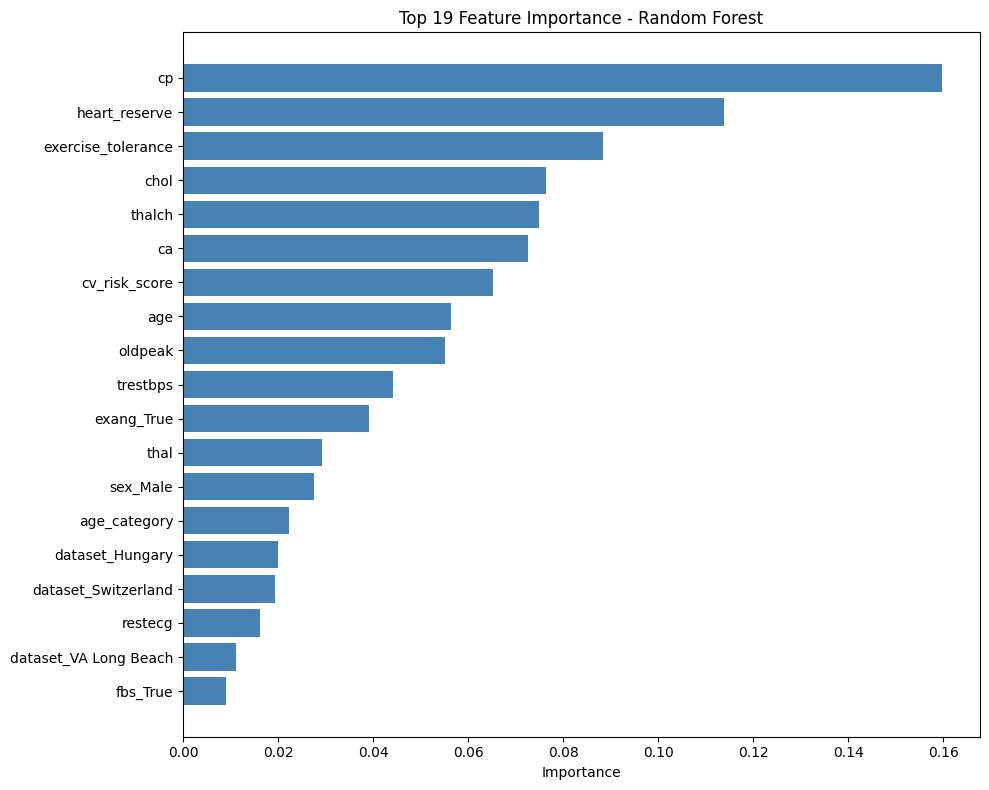

In [97]:
# =============================================================================
# ANALIZA FEATURE IMPORTANCE (dla Random Forest)
# =============================================================================

print(f"\n{'='*80}")
print("FEATURE IMPORTANCE - Random Forest")
print(f"{'='*80}")

# Wytrenuj RF na najlepszym datasecie
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

# Pobierz ważności cech
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("19 cech(ważność/istotność):")
display(feature_importance.head(22))

# Wizualizacja
plt.figure(figsize=(10, 8))
plt.barh(range(19), feature_importance['importance'].head(19), color='steelblue')
plt.yticks(range(19), feature_importance['feature'].head(19))
plt.xlabel('Importance')
plt.title('Top 19 Feature Importance - Random Forest')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [98]:
# =============================================================================
# BACKUP WYNIKÓW przed dalszymi operacjami
# =============================================================================
all_results_backup = {k: v.copy() for k, v in all_results.items()}
print("\n✅ Utworzono backup wyników przed modelami zespołowymi")


✅ Utworzono backup wyników przed modelami zespołowymi


In [99]:
# =============================================================================
# MODELE ZESPOŁOWE - VOTING (dla najlepszego datasetu)
# =============================================================================

from sklearn.ensemble import VotingClassifier

best_dataset_name = best_overall['Dataset']
best_data = prepared_datasets[best_dataset_name]

X_train = best_data['X_train']
X_test = best_data['X_test']
y_train = best_data['y_train']
y_test = best_data['y_test']

print(f"\n{'='*80}")
print(f"MODELE ZESPOŁOWE - Dataset: {best_dataset_name}")
print(f"{'='*80}")

# Voting Soft
voting_soft = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(max_iter=1000, random_state=42)),
        ('rf', RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)),
        ('svm', SVC(kernel='rbf', probability=True, random_state=42))
    ],
    voting='soft'
)

voting_soft.fit(X_train, y_train)
y_pred_voting = voting_soft.predict(X_test)
y_proba_voting = voting_soft.predict_proba(X_test)[:, 1]

voting_results = evaluate_model(y_test, y_pred_voting, y_proba_voting)

print("\nVoting Classifier (Soft):")
for metric, value in voting_results.items():
    print(f"  {metric}: {value:.4f}")


MODELE ZESPOŁOWE - Dataset: mean_minmax

Voting Classifier (Soft):
  Accuracy: 0.7978
  Precision: 0.8077
  Recall: 0.8317
  F1-Score: 0.8195
  Specificity: 0.7561
  ROC AUC: 0.8916


In [100]:
# =============================================================================
# MODELE ZESPOŁOWE - STACKING (dla najlepszego datasetu)
# =============================================================================

from sklearn.ensemble import StackingClassifier

stacking = StackingClassifier(
    estimators=[
        ('lr', LogisticRegression(max_iter=1000, random_state=42)),
        ('dt', DecisionTreeClassifier(max_depth=10, random_state=42)),
        ('rf', RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42))
    ],
    final_estimator=LogisticRegression(max_iter=1000, random_state=42),
    cv=5
)

stacking.fit(X_train, y_train)
y_pred_stacking = stacking.predict(X_test)
y_proba_stacking = stacking.predict_proba(X_test)[:, 1]

stacking_results = evaluate_model(y_test, y_pred_stacking, y_proba_stacking)

print("\nStacking Classifier:")
for metric, value in stacking_results.items():
    print(f"  {metric}: {value:.4f}")

# Dodanie wyników zespołowych TYLKO do najlepszego datasetu
all_results[best_dataset_name]['Voting (Soft)'] = voting_results
all_results[best_dataset_name]['Stacking'] = stacking_results


Stacking Classifier:
  Accuracy: 0.7978
  Precision: 0.8137
  Recall: 0.8218
  F1-Score: 0.8177
  Specificity: 0.7683
  ROC AUC: 0.8927


In [101]:
print("\n" + "="*80)
print("WYNIKI WSZYSTKICH MODELI NA WSZYSTKICH DATASETACH")
print("="*80)

# Iteracja przez wszystkie datasety
for dataset_name in sorted(all_results.keys()):
    print(f"\n{'='*80}")
    print(f"DATASET: {dataset_name}")
    print(f"{'='*80}")

    # Konwersja słownika wyników na DataFrame
    results_df = pd.DataFrame(all_results[dataset_name]).T

    # Sortowanie według F1-Score (malejąco)
    results_df = results_df.sort_values('F1-Score', ascending=False)

    # Wyświetlenie tabeli
    display(results_df.round(4))

    # Dodatkowe statystyki dla datasetu
    print(f"\nNajlepszy model: {results_df.index[0]}")
    print(f"F1-Score: {results_df['F1-Score'].iloc[0]:.4f}")
    print(f"Accuracy: {results_df['Accuracy'].iloc[0]:.4f}")
    if 'ROC AUC' in results_df.columns:
        print(f"ROC AUC: {results_df['ROC AUC'].iloc[0]:.4f}")
    print(f"Liczba modeli: {len(results_df)}")


WYNIKI WSZYSTKICH MODELI NA WSZYSTKICH DATASETACH

DATASET: constant0_minmax


,Accuracy,Precision,Recall,F1-Score,Specificity,ROC AUC
Logistic Regression,0.8087,0.8173,0.8416,0.8293,0.7683,0.8847
SVM,0.8087,0.8173,0.8416,0.8293,0.7683,0.8870
Random Forest,0.7978,0.8200,0.8119,0.8159,0.7805,0.8729
Decision Tree,0.7923,0.8119,0.8119,0.8119,0.7683,0.8611
XGBoost,0.7760,0.7941,0.8020,0.7980,0.7439,0.8621
LightGBM,0.7705,0.7921,0.7921,0.7921,0.7439,0.8540



Najlepszy model: Logistic Regression
F1-Score: 0.8293
Accuracy: 0.8087
ROC AUC: 0.8847
Liczba modeli: 6

DATASET: constant0_zscore


,Accuracy,Precision,Recall,F1-Score,Specificity,ROC AUC
Logistic Regression,0.7978,0.8077,0.8317,0.8195,0.7561,0.8742
Random Forest,0.7978,0.8137,0.8218,0.8177,0.7683,0.8735
Decision Tree,0.7923,0.8119,0.8119,0.8119,0.7683,0.8611
SVM,0.7814,0.8020,0.8020,0.8020,0.7561,0.8736
XGBoost,0.7760,0.7941,0.8020,0.7980,0.7439,0.8621
LightGBM,0.7814,0.8144,0.7822,0.7980,0.7805,0.8551



Najlepszy model: Logistic Regression
F1-Score: 0.8195
Accuracy: 0.7978
ROC AUC: 0.8742
Liczba modeli: 6

DATASET: mean_minmax


,Accuracy,Precision,Recall,F1-Score,Specificity,ROC AUC
SVM,0.8087,0.8173,0.8416,0.8293,0.7683,0.8870
Logistic Regression,0.8033,0.8095,0.8416,0.8252,0.7561,0.8844
Voting (Soft),0.7978,0.8077,0.8317,0.8195,0.7561,0.8916
Random Forest,0.7978,0.8137,0.8218,0.8177,0.7683,0.8749
Stacking,0.7978,0.8137,0.8218,0.8177,0.7683,0.8927
Decision Tree,0.7923,0.8119,0.8119,0.8119,0.7683,0.8611
LightGBM,0.7923,0.8182,0.8020,0.8100,0.7805,0.8539
XGBoost,0.7814,0.7961,0.8119,0.8039,0.7439,0.8608



Najlepszy model: SVM
F1-Score: 0.8293
Accuracy: 0.8087
ROC AUC: 0.8870
Liczba modeli: 8

DATASET: mean_zscore


,Accuracy,Precision,Recall,F1-Score,Specificity,ROC AUC
Logistic Regression,0.7978,0.8077,0.8317,0.8195,0.7561,0.8738
Random Forest,0.7978,0.8137,0.8218,0.8177,0.7683,0.8749
Decision Tree,0.7923,0.8119,0.8119,0.8119,0.7683,0.8611
XGBoost,0.7814,0.7961,0.8119,0.8039,0.7439,0.8608
SVM,0.7814,0.8020,0.8020,0.8020,0.7561,0.8736
LightGBM,0.7760,0.7941,0.8020,0.7980,0.7439,0.8541



Najlepszy model: Logistic Regression
F1-Score: 0.8195
Accuracy: 0.7978
ROC AUC: 0.8738
Liczba modeli: 6

DATASET: median_minmax


,Accuracy,Precision,Recall,F1-Score,Specificity,ROC AUC
SVM,0.8087,0.8173,0.8416,0.8293,0.7683,0.8870
Logistic Regression,0.8033,0.8095,0.8416,0.8252,0.7561,0.8846
LightGBM,0.8033,0.8283,0.8119,0.8200,0.7927,0.8552
Decision Tree,0.7923,0.8119,0.8119,0.8119,0.7683,0.8611
Random Forest,0.7869,0.8039,0.8119,0.8079,0.7561,0.8742
XGBoost,0.7814,0.7961,0.8119,0.8039,0.7439,0.8603



Najlepszy model: SVM
F1-Score: 0.8293
Accuracy: 0.8087
ROC AUC: 0.8870
Liczba modeli: 6

DATASET: median_zscore


,Accuracy,Precision,Recall,F1-Score,Specificity,ROC AUC
Logistic Regression,0.7978,0.8077,0.8317,0.8195,0.7561,0.8739
Decision Tree,0.7923,0.8119,0.8119,0.8119,0.7683,0.8611
Random Forest,0.7869,0.8039,0.8119,0.8079,0.7561,0.8744
XGBoost,0.7814,0.7961,0.8119,0.8039,0.7439,0.8603
SVM,0.7814,0.8020,0.8020,0.8020,0.7561,0.8736
LightGBM,0.7705,0.7980,0.7822,0.7900,0.7561,0.8552



Najlepszy model: Logistic Regression
F1-Score: 0.8195
Accuracy: 0.7978
ROC AUC: 0.8739
Liczba modeli: 6

DATASET: most_frequent_minmax


,Accuracy,Precision,Recall,F1-Score,Specificity,ROC AUC
SVM,0.8087,0.8173,0.8416,0.8293,0.7683,0.8870
Logistic Regression,0.8033,0.8095,0.8416,0.8252,0.7561,0.8844
Random Forest,0.7869,0.8039,0.8119,0.8079,0.7561,0.8727
XGBoost,0.7760,0.7941,0.8020,0.7980,0.7439,0.8555
LightGBM,0.7705,0.7980,0.7822,0.7900,0.7561,0.8518
Decision Tree,0.7486,0.7723,0.7723,0.7723,0.7195,0.8627



Najlepszy model: SVM
F1-Score: 0.8293
Accuracy: 0.8087
ROC AUC: 0.8870
Liczba modeli: 6

DATASET: most_frequent_zscore


,Accuracy,Precision,Recall,F1-Score,Specificity,ROC AUC
Logistic Regression,0.7978,0.8077,0.8317,0.8195,0.7561,0.8738
Random Forest,0.7869,0.8039,0.8119,0.8079,0.7561,0.8731
SVM,0.7814,0.8020,0.8020,0.8020,0.7561,0.8736
XGBoost,0.7760,0.7941,0.8020,0.7980,0.7439,0.8555
LightGBM,0.7760,0.8000,0.7921,0.7960,0.7561,0.8586
Decision Tree,0.7486,0.7723,0.7723,0.7723,0.7195,0.8627



Najlepszy model: Logistic Regression
F1-Score: 0.8195
Accuracy: 0.7978
ROC AUC: 0.8738
Liczba modeli: 6


In [102]:
# =============================================================================
# PORÓWNANIE Z MODELAMI ZESPOŁOWYMI
# =============================================================================

print(f"\n{'='*80}")
print(f"PORÓWNANIE WSZYSTKICH MODELI - {best_dataset_name}")
print(f"{'='*80}")

final_comparison = pd.DataFrame(all_results[best_dataset_name]).T
final_comparison = final_comparison.sort_values('F1-Score', ascending=False)
display(final_comparison.round(4))


PORÓWNANIE WSZYSTKICH MODELI - mean_minmax


,Accuracy,Precision,Recall,F1-Score,Specificity,ROC AUC
SVM,0.8087,0.8173,0.8416,0.8293,0.7683,0.8870
Logistic Regression,0.8033,0.8095,0.8416,0.8252,0.7561,0.8844
Voting (Soft),0.7978,0.8077,0.8317,0.8195,0.7561,0.8916
Random Forest,0.7978,0.8137,0.8218,0.8177,0.7683,0.8749
Stacking,0.7978,0.8137,0.8218,0.8177,0.7683,0.8927
Decision Tree,0.7923,0.8119,0.8119,0.8119,0.7683,0.8611
LightGBM,0.7923,0.8182,0.8020,0.8100,0.7805,0.8539
XGBoost,0.7814,0.7961,0.8119,0.8039,0.7439,0.8608


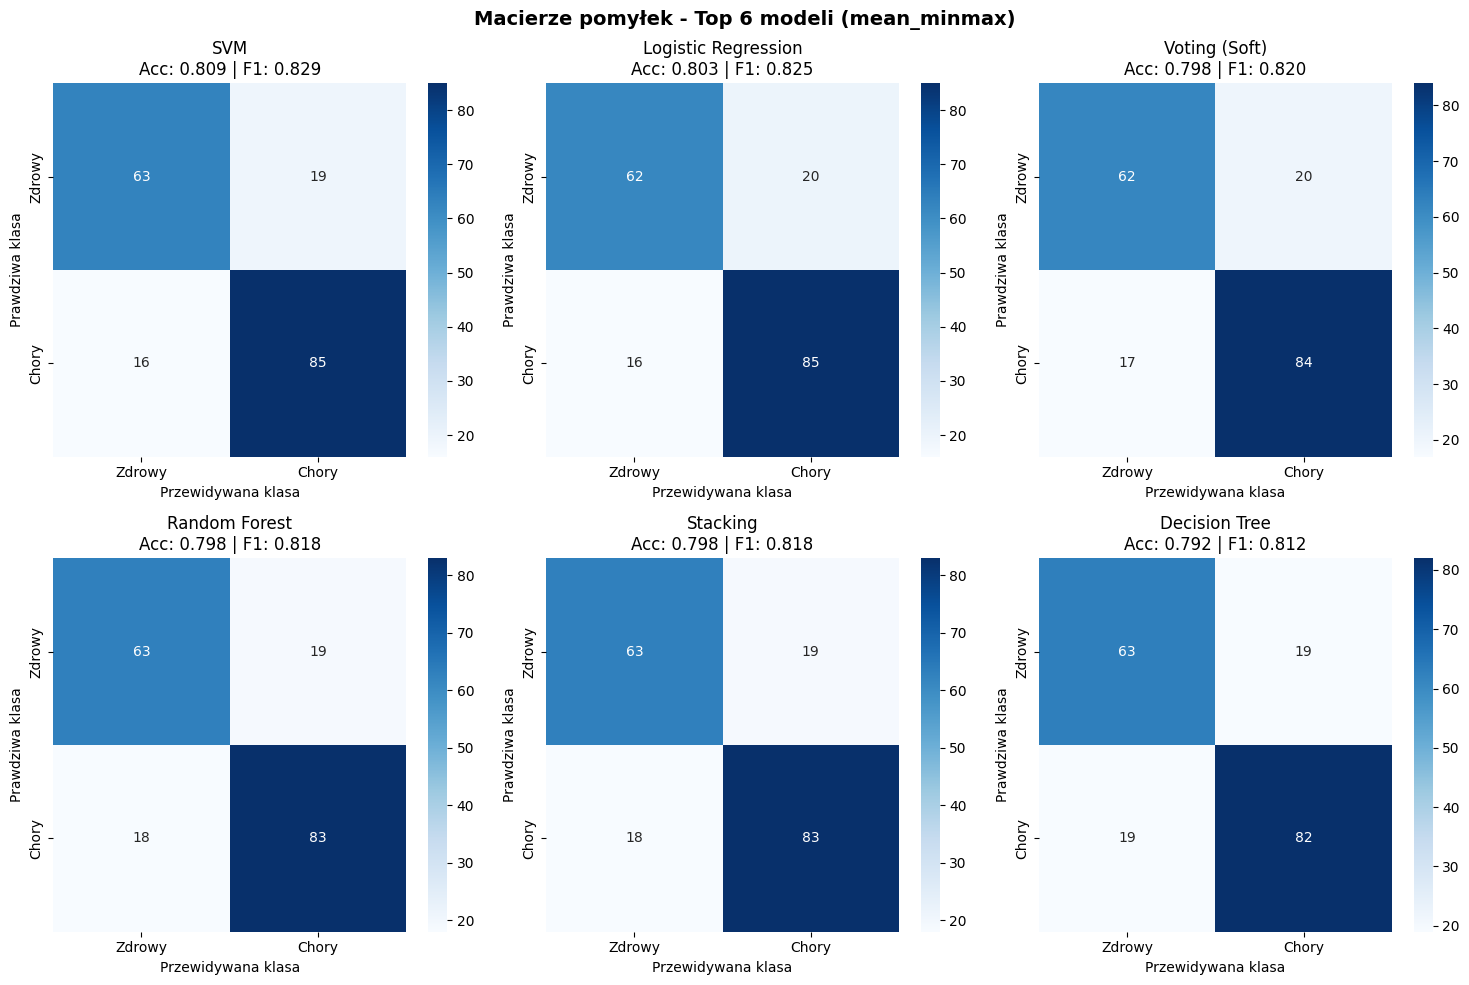

In [103]:
# =============================================================================
# MACIERZE POMYŁEK - TOP 6 MODELI
# =============================================================================

import matplotlib.pyplot as plt
import seaborn as sns

# Trenowanie top 6 modeli dla wizualizacji
top_models_names = final_comparison.head(6).index.tolist()

models_for_viz = {}
for model_name in top_models_names:
    if model_name == 'Voting (Soft)':
        models_for_viz[model_name] = voting_soft
    elif model_name == 'Stacking':
        models_for_viz[model_name] = stacking
    elif model_name == 'Logistic Regression':
        model = LogisticRegression(max_iter=1000, random_state=42)
        model.fit(X_train, y_train)
        models_for_viz[model_name] = model
    elif model_name == 'Decision Tree':
        model = DecisionTreeClassifier(max_depth=10, random_state=42)
        model.fit(X_train, y_train)
        models_for_viz[model_name] = model
    elif model_name == 'Random Forest':
        model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
        model.fit(X_train, y_train)
        models_for_viz[model_name] = model
    elif model_name == 'SVM':
        model = SVC(kernel='rbf', probability=True, random_state=42)
        model.fit(X_train, y_train)
        models_for_viz[model_name] = model
    elif model_name == 'XGBoost':
        try:
            from xgboost import XGBClassifier
            model = XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42, eval_metric='logloss')
            model.fit(X_train, y_train)
            models_for_viz[model_name] = model
        except:
            pass
    elif model_name == 'LightGBM':
        try:
            from lightgbm import LGBMClassifier
            model = LGBMClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42, verbose=-1)
            model.fit(X_train, y_train)
            models_for_viz[model_name] = model
        except:
            pass

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, (name, model) in enumerate(models_for_viz.items()):
    if idx >= 6:
        break

    y_pred = model.predict(X_test)
    cm = manual_confusion_matrix(y_test, y_pred)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Zdrowy', 'Chory'],
                yticklabels=['Zdrowy', 'Chory'])
    axes[idx].set_title(f'{name}\nAcc: {manual_accuracy(y_test, y_pred):.3f} | F1: {manual_f1_score(y_test, y_pred):.3f}')
    axes[idx].set_ylabel('Prawdziwa klasa')
    axes[idx].set_xlabel('Przewidywana klasa')

for idx in range(len(models_for_viz), 6):
    fig.delaxes(axes[idx])

plt.suptitle(f'Macierze pomyłek - Top 6 modeli ({best_dataset_name})', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

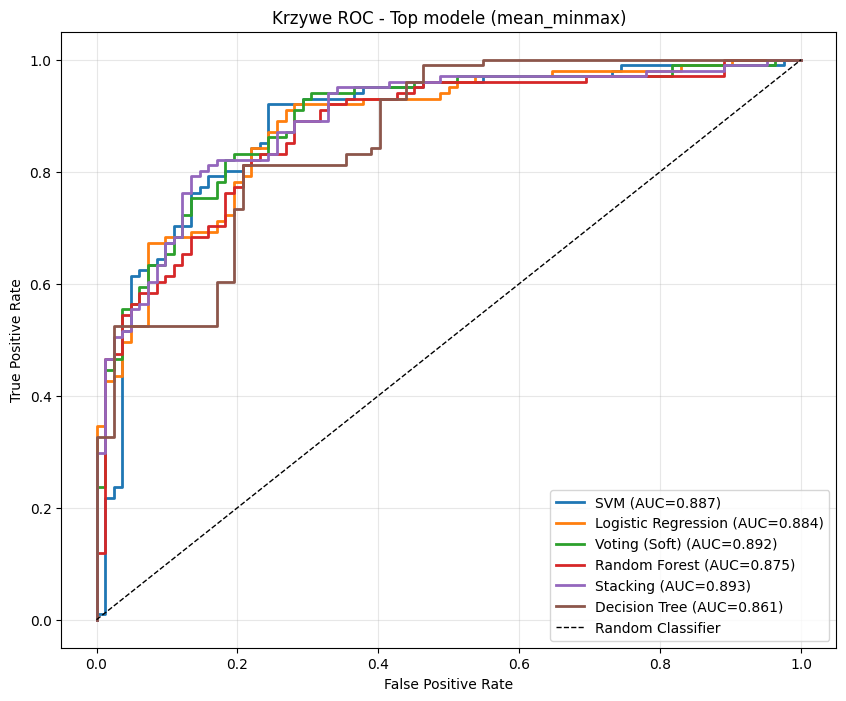

In [104]:
# =============================================================================
# KRZYWE ROC
# =============================================================================

plt.figure(figsize=(10, 8))

for name, model in models_for_viz.items():
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test)[:, 1]

        y_true_sorted_idx = np.argsort(y_proba)[::-1]
        y_true_sorted = np.array(y_test)[y_true_sorted_idx]

        tpr_list, fpr_list = [0], [0]
        tp = fp = 0
        n_pos = np.sum(y_test == 1)
        n_neg = np.sum(y_test == 0)

        for label in y_true_sorted:
            if label == 1:
                tp += 1
            else:
                fp += 1
            tpr = tp / n_pos if n_pos > 0 else 0
            fpr = fp / n_neg if n_neg > 0 else 0
            tpr_list.append(tpr)
            fpr_list.append(fpr)

        auc = manual_roc_auc(y_test, y_proba)
        plt.plot(fpr_list, tpr_list, label=f'{name} (AUC={auc:.3f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Krzywe ROC - Top modele ({best_dataset_name})')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

In [105]:
# =============================================================================
# WALIDACJA KRZYŻOWA - RĘCZNA IMPLEMENTACJA
# =============================================================================

def manual_kfold_split(X, y, n_splits=5, random_state=None):
    """Ręczna implementacja K-Fold ze stratyfikacją."""
    if random_state is not None:
        np.random.seed(random_state)

    n = len(X)
    indices = np.arange(n)

    unique_classes = np.unique(y)
    folds = [[] for _ in range(n_splits)]

    for cls in unique_classes:
        cls_indices = indices[y == cls]
        np.random.shuffle(cls_indices)

        fold_sizes = np.full(n_splits, len(cls_indices) // n_splits)
        fold_sizes[:len(cls_indices) % n_splits] += 1

        current = 0
        for fold_idx, size in enumerate(fold_sizes):
            folds[fold_idx].extend(cls_indices[current:current + size])
            current += size

    splits = []
    for i in range(n_splits):
        val_idx = np.array(folds[i])
        train_idx = np.array([idx for j in range(n_splits) if j != i for idx in folds[j]])
        splits.append((train_idx, val_idx))

    return splits

def cross_validate_manual(model, X, y, cv=5, random_state=42):
    """Ręczna walidacja krzyżowa z obliczaniem metryk."""
    splits = manual_kfold_split(X, y, n_splits=cv, random_state=random_state)

    fold_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1_score': [],
        'roc_auc': []
    }

    for fold_idx, (train_idx, val_idx) in enumerate(splits):
        if isinstance(X, pd.DataFrame):
            X_fold_train, X_fold_val = X.iloc[train_idx], X.iloc[val_idx]
        else:
            X_fold_train, X_fold_val = X[train_idx], X[val_idx]

        if isinstance(y, pd.Series):
            y_fold_train, y_fold_val = y.iloc[train_idx], y.iloc[val_idx]
        else:
            y_fold_train, y_fold_val = y[train_idx], y[val_idx]

        from sklearn.base import clone
        model_clone = clone(model)
        model_clone.fit(X_fold_train, y_fold_train)

        y_pred = model_clone.predict(X_fold_val)
        y_proba = model_clone.predict_proba(X_fold_val)[:, 1] if hasattr(model_clone, 'predict_proba') else None

        fold_results['accuracy'].append(manual_accuracy(y_fold_val, y_pred))
        fold_results['precision'].append(manual_precision(y_fold_val, y_pred))
        fold_results['recall'].append(manual_recall(y_fold_val, y_pred))
        fold_results['f1_score'].append(manual_f1_score(y_fold_val, y_pred))

        if y_proba is not None:
            fold_results['roc_auc'].append(manual_roc_auc(y_fold_val, y_proba))

    cv_results = {}
    for metric, values in fold_results.items():
        cv_results[f'{metric}_mean'] = np.mean(values)
        cv_results[f'{metric}_std'] = np.std(values)

    return cv_results, fold_results

In [106]:
# =============================================================================
# WALIDACJA KRZYŻOWA - NAJLEPSZY MODEL NA NAJLEPSZYM DATASECIE
# =============================================================================

print(f"\n{'='*80}")
print(f"WALIDACJA KRZYŻOWA - {best_overall['Best Model']} na {best_dataset_name}")
print(f"{'='*80}")

# Przygotowanie pełnego datasetu (X, y)
best_df = datasets[best_dataset_name].copy()
cols_to_drop = ['num', 'dataset_origin']
best_df = best_df.drop(columns=[c for c in cols_to_drop if c in best_df.columns], errors='ignore')

if 'has_disease' not in best_df.columns:
    best_df['has_disease'] = (datasets[best_dataset_name]['num'] > 0).astype(int)

X_full = best_df[[c for c in best_df.columns if c != 'has_disease']]
y_full = best_df['has_disease']

# Model do walidacji krzyżowej
if best_overall['Best Model'] == 'Random Forest':
    cv_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
elif best_overall['Best Model'] == 'Logistic Regression':
    cv_model = LogisticRegression(max_iter=1000, random_state=42)
elif best_overall['Best Model'] == 'SVM':
    cv_model = SVC(kernel='rbf', probability=True, random_state=42)
elif best_overall['Best Model'] == 'Decision Tree':
    cv_model = DecisionTreeClassifier(max_depth=10, random_state=42)
elif best_overall['Best Model'] == 'XGBoost':
    from xgboost import XGBClassifier
    cv_model = XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42, eval_metric='logloss')
elif best_overall['Best Model'] == 'LightGBM':
    from lightgbm import LGBMClassifier
    cv_model = LGBMClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42, verbose=-1)
else:
    cv_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

cv_results, fold_results = cross_validate_manual(cv_model, X_full, y_full, cv=5, random_state=42)

print("\nWyniki walidacji krzyżowej (5-fold):")
for metric in ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']:
    mean_val = cv_results[f'{metric}_mean']
    std_val = cv_results[f'{metric}_std']
    print(f"{metric.upper():12s}: {mean_val:.4f} ± {std_val:.4f}")

print("\nWyniki dla poszczególnych foldów:")
fold_df = pd.DataFrame(fold_results)
fold_df.index = [f'Fold {i+1}' for i in range(len(fold_df))]
display(fold_df.round(4))


WALIDACJA KRZYŻOWA - SVM na mean_minmax

Wyniki walidacji krzyżowej (5-fold):
ACCURACY    : 0.8348 ± 0.0171
PRECISION   : 0.8395 ± 0.0150
RECALL      : 0.8685 ± 0.0448
F1_SCORE    : 0.8528 ± 0.0192
ROC_AUC     : 0.9071 ± 0.0163

Wyniki dla poszczególnych foldów:


,accuracy,precision,recall,f1_score,roc_auc
Fold 1,0.8324,0.8381,0.8627,0.8502,0.9003
Fold 2,0.8315,0.8198,0.8922,0.8545,0.8863
Fold 3,0.8370,0.8273,0.8922,0.8585,0.9155
Fold 4,0.8098,0.8602,0.7843,0.8205,0.8997
Fold 5,0.8634,0.8519,0.9109,0.8804,0.9340



PORÓWNANIE: Train/Test vs Walidacja Krzyżowa


,Train/Test Split,Cross-Validation (5-fold),CV Std Dev
Accuracy,0.8087,0.8348,0.0171
F1-Score,0.8293,0.8528,0.0192
Precision,0.8173,0.8395,0.0150
ROC AUC,0.8870,0.9071,0.0163
Recall,0.8416,0.8685,0.0448
Specificity,0.7683,NaN,NaN


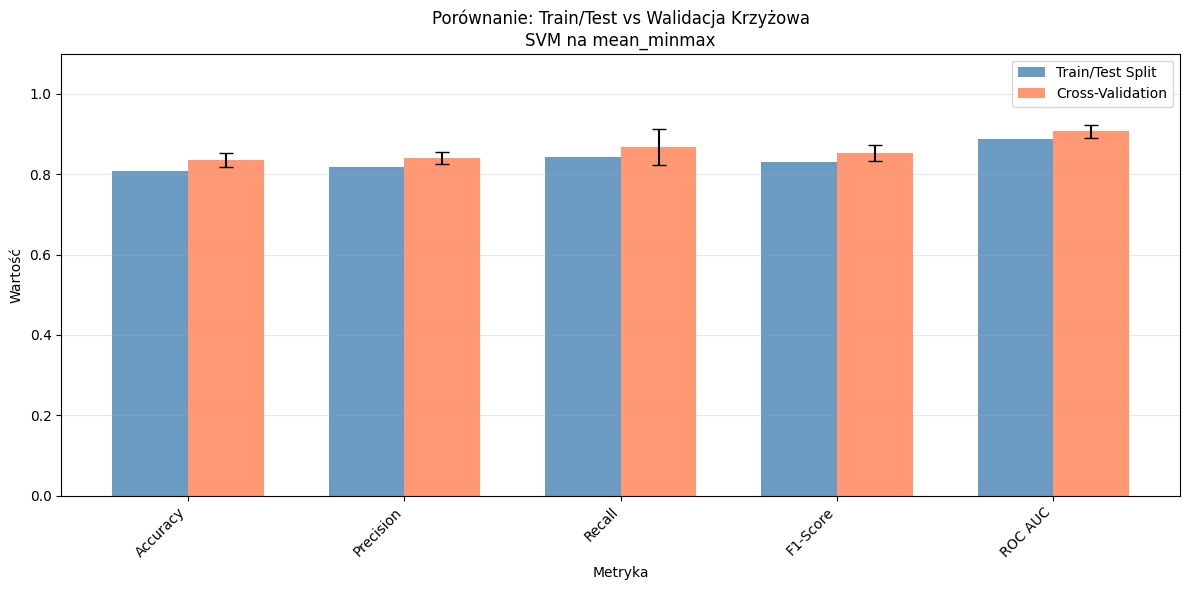


✅ Analiza zakończona. Realizacja na wszystkich 8 datasetach:
   • Najlepszy dataset: mean_minmax
   • Najlepszy model: SVM
   • F1-Score (train/test): 0.8293
   • F1-Score (CV 5-fold): 0.8528 ± 0.0192


In [107]:
# =============================================================================
# PORÓWNANIE: TRAIN/TEST vs WALIDACJA KRZYŻOWA
# =============================================================================

print(f"\n{'='*80}")
print("PORÓWNANIE: Train/Test vs Walidacja Krzyżowa")
print(f"{'='*80}")

# Wyniki z train/test
results_train_test = all_results[best_dataset_name][best_overall['Best Model']]

# Wyniki z CV
results_cv = {
    'Accuracy': cv_results['accuracy_mean'],
    'Precision': cv_results['precision_mean'],
    'Recall': cv_results['recall_mean'],
    'F1-Score': cv_results['f1_score_mean'],
    'ROC AUC': cv_results['roc_auc_mean']
}

# Odchylenia standardowe CV
results_cv_std = {
    'Accuracy': cv_results['accuracy_std'],
    'Precision': cv_results['precision_std'],
    'Recall': cv_results['recall_std'],
    'F1-Score': cv_results['f1_score_std'],
    'ROC AUC': cv_results['roc_auc_std']
}

# Tabela porównawcza
comparison_df = pd.DataFrame({
    'Train/Test Split': pd.Series(results_train_test),
    'Cross-Validation (5-fold)': pd.Series(results_cv),
    'CV Std Dev': pd.Series(results_cv_std)
})

display(comparison_df.round(4))

# Wizualizacja porównania
fig, ax = plt.subplots(figsize=(12, 6))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC']
x = np.arange(len(metrics))
width = 0.35

tt_values = [results_train_test[m] for m in metrics]
cv_values = [results_cv[m] for m in metrics]
cv_stds = [results_cv_std[m] for m in metrics]

ax.bar(x - width/2, tt_values, width, label='Train/Test Split', color='steelblue', alpha=0.8)
ax.bar(x + width/2, cv_values, width, label='Cross-Validation', color='coral', alpha=0.8, yerr=cv_stds, capsize=5)

ax.set_xlabel('Metryka')
ax.set_ylabel('Wartość')
ax.set_title(f'Porównanie: Train/Test vs Walidacja Krzyżowa\n{best_overall["Best Model"]} na {best_dataset_name}')
ax.set_xticks(x)
ax.set_xticklabels(metrics, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(0, 1.1)

plt.tight_layout()
plt.show()

print("\n✅ Analiza zakończona. Realizacja na wszystkich 8 datasetach:")
print(f"   • Najlepszy dataset: {best_dataset_name}")
print(f"   • Najlepszy model: {best_overall['Best Model']}")
print(f"   • F1-Score (train/test): {results_train_test['F1-Score']:.4f}")
print(f"   • F1-Score (CV 5-fold): {results_cv['F1-Score']:.4f} ± {results_cv_std['F1-Score']:.4f}")

In [108]:
# =============================================================================
# DODATKOWA WALIDACJA KRZYŻOWA DLA INNYCH MODELI
# =============================================================================

print("\n" + "="*80)
print("WALIDACJA KRZYŻOWA - Porównanie wybranych modeli")
print("="*80)

models_for_cv = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42)
}

cv_comparison = {}

for name, model in models_for_cv.items():
    cv_res, _ = cross_validate_manual(model, X, y, cv=5, random_state=42)
    cv_comparison[name] = {
        'F1-Score': cv_res['f1_score_mean'],
        'F1-Std': cv_res['f1_score_std'],
        'Accuracy': cv_res['accuracy_mean'],
        'ROC AUC': cv_res['roc_auc_mean']
    }

cv_comparison_df = pd.DataFrame(cv_comparison).T
cv_comparison_df = cv_comparison_df.sort_values('F1-Score', ascending=False)
display(cv_comparison_df.round(4))


WALIDACJA KRZYŻOWA - Porównanie wybranych modeli


,F1-Score,F1-Std,Accuracy,ROC AUC
Logistic Regression,0.8475,0.0183,0.8305,0.9027
SVM,0.8385,0.0215,0.8207,0.8973
Random Forest,0.8338,0.0183,0.8142,0.8910


In [109]:
for dataset_name, dataset_results in all_results.items():
    print(f"\n{'='*80}")
    print(f"DATASET: {dataset_name}")
    print(f"{'='*80}")

    results_df = pd.DataFrame(dataset_results).T  # przekształcenie do DataFrame
    display(results_df.round(4))



DATASET: mean_minmax


,Accuracy,Precision,Recall,F1-Score,Specificity,ROC AUC
Logistic Regression,0.8033,0.8095,0.8416,0.8252,0.7561,0.8844
Decision Tree,0.7923,0.8119,0.8119,0.8119,0.7683,0.8611
Random Forest,0.7978,0.8137,0.8218,0.8177,0.7683,0.8749
SVM,0.8087,0.8173,0.8416,0.8293,0.7683,0.8870
XGBoost,0.7814,0.7961,0.8119,0.8039,0.7439,0.8608
LightGBM,0.7923,0.8182,0.8020,0.8100,0.7805,0.8539
Voting (Soft),0.7978,0.8077,0.8317,0.8195,0.7561,0.8916
Stacking,0.7978,0.8137,0.8218,0.8177,0.7683,0.8927



DATASET: mean_zscore


,Accuracy,Precision,Recall,F1-Score,Specificity,ROC AUC
Logistic Regression,0.7978,0.8077,0.8317,0.8195,0.7561,0.8738
Decision Tree,0.7923,0.8119,0.8119,0.8119,0.7683,0.8611
Random Forest,0.7978,0.8137,0.8218,0.8177,0.7683,0.8749
SVM,0.7814,0.8020,0.8020,0.8020,0.7561,0.8736
XGBoost,0.7814,0.7961,0.8119,0.8039,0.7439,0.8608
LightGBM,0.7760,0.7941,0.8020,0.7980,0.7439,0.8541



DATASET: median_minmax


,Accuracy,Precision,Recall,F1-Score,Specificity,ROC AUC
Logistic Regression,0.8033,0.8095,0.8416,0.8252,0.7561,0.8846
Decision Tree,0.7923,0.8119,0.8119,0.8119,0.7683,0.8611
Random Forest,0.7869,0.8039,0.8119,0.8079,0.7561,0.8742
SVM,0.8087,0.8173,0.8416,0.8293,0.7683,0.8870
XGBoost,0.7814,0.7961,0.8119,0.8039,0.7439,0.8603
LightGBM,0.8033,0.8283,0.8119,0.8200,0.7927,0.8552



DATASET: median_zscore


,Accuracy,Precision,Recall,F1-Score,Specificity,ROC AUC
Logistic Regression,0.7978,0.8077,0.8317,0.8195,0.7561,0.8739
Decision Tree,0.7923,0.8119,0.8119,0.8119,0.7683,0.8611
Random Forest,0.7869,0.8039,0.8119,0.8079,0.7561,0.8744
SVM,0.7814,0.8020,0.8020,0.8020,0.7561,0.8736
XGBoost,0.7814,0.7961,0.8119,0.8039,0.7439,0.8603
LightGBM,0.7705,0.7980,0.7822,0.7900,0.7561,0.8552



DATASET: most_frequent_minmax


,Accuracy,Precision,Recall,F1-Score,Specificity,ROC AUC
Logistic Regression,0.8033,0.8095,0.8416,0.8252,0.7561,0.8844
Decision Tree,0.7486,0.7723,0.7723,0.7723,0.7195,0.8627
Random Forest,0.7869,0.8039,0.8119,0.8079,0.7561,0.8727
SVM,0.8087,0.8173,0.8416,0.8293,0.7683,0.8870
XGBoost,0.7760,0.7941,0.8020,0.7980,0.7439,0.8555
LightGBM,0.7705,0.7980,0.7822,0.7900,0.7561,0.8518



DATASET: most_frequent_zscore


,Accuracy,Precision,Recall,F1-Score,Specificity,ROC AUC
Logistic Regression,0.7978,0.8077,0.8317,0.8195,0.7561,0.8738
Decision Tree,0.7486,0.7723,0.7723,0.7723,0.7195,0.8627
Random Forest,0.7869,0.8039,0.8119,0.8079,0.7561,0.8731
SVM,0.7814,0.8020,0.8020,0.8020,0.7561,0.8736
XGBoost,0.7760,0.7941,0.8020,0.7980,0.7439,0.8555
LightGBM,0.7760,0.8000,0.7921,0.7960,0.7561,0.8586



DATASET: constant0_minmax


,Accuracy,Precision,Recall,F1-Score,Specificity,ROC AUC
Logistic Regression,0.8087,0.8173,0.8416,0.8293,0.7683,0.8847
Decision Tree,0.7923,0.8119,0.8119,0.8119,0.7683,0.8611
Random Forest,0.7978,0.8200,0.8119,0.8159,0.7805,0.8729
SVM,0.8087,0.8173,0.8416,0.8293,0.7683,0.8870
XGBoost,0.7760,0.7941,0.8020,0.7980,0.7439,0.8621
LightGBM,0.7705,0.7921,0.7921,0.7921,0.7439,0.8540



DATASET: constant0_zscore


,Accuracy,Precision,Recall,F1-Score,Specificity,ROC AUC
Logistic Regression,0.7978,0.8077,0.8317,0.8195,0.7561,0.8742
Decision Tree,0.7923,0.8119,0.8119,0.8119,0.7683,0.8611
Random Forest,0.7978,0.8137,0.8218,0.8177,0.7683,0.8735
SVM,0.7814,0.8020,0.8020,0.8020,0.7561,0.8736
XGBoost,0.7760,0.7941,0.8020,0.7980,0.7439,0.8621
LightGBM,0.7814,0.8144,0.7822,0.7980,0.7805,0.8551


In [110]:
# =============================================================================
# WYŚWIETLANIE WYNIKÓW DLA WSZYSTKICH DATASETÓW I MODELI
# =============================================================================

print("\n" + "="*80)
print("WYNIKI WSZYSTKICH MODELI NA WSZYSTKICH DATASETACH")
print("="*80)

# Iteracja przez wszystkie datasety
for dataset_name, dataset_results in all_results.items():
    print(f"\n{'='*80}")
    print(f"DATASET: {dataset_name}")
    print(f"{'='*80}")

    # Konwersja słownika wyników na DataFrame
    results_df = pd.DataFrame(dataset_results).T

    # Sortowanie według F1-Score (malejąco)
    results_df = results_df.sort_values('F1-Score', ascending=False)

    # Wyświetlenie tabeli
    display(results_df.round(4))

    # Dodatkowe statystyki dla datasetu
    print(f"\nNajlepszy model: {results_df.index[0]}")
    print(f"F1-Score: {results_df['F1-Score'].iloc[0]:.4f}")
    print(f"Accuracy: {results_df['Accuracy'].iloc[0]:.4f}")
    if 'ROC AUC' in results_df.columns:
        print(f"ROC AUC: {results_df['ROC AUC'].iloc[0]:.4f}")


WYNIKI WSZYSTKICH MODELI NA WSZYSTKICH DATASETACH

DATASET: mean_minmax


,Accuracy,Precision,Recall,F1-Score,Specificity,ROC AUC
SVM,0.8087,0.8173,0.8416,0.8293,0.7683,0.8870
Logistic Regression,0.8033,0.8095,0.8416,0.8252,0.7561,0.8844
Voting (Soft),0.7978,0.8077,0.8317,0.8195,0.7561,0.8916
Random Forest,0.7978,0.8137,0.8218,0.8177,0.7683,0.8749
Stacking,0.7978,0.8137,0.8218,0.8177,0.7683,0.8927
Decision Tree,0.7923,0.8119,0.8119,0.8119,0.7683,0.8611
LightGBM,0.7923,0.8182,0.8020,0.8100,0.7805,0.8539
XGBoost,0.7814,0.7961,0.8119,0.8039,0.7439,0.8608



Najlepszy model: SVM
F1-Score: 0.8293
Accuracy: 0.8087
ROC AUC: 0.8870

DATASET: mean_zscore


,Accuracy,Precision,Recall,F1-Score,Specificity,ROC AUC
Logistic Regression,0.7978,0.8077,0.8317,0.8195,0.7561,0.8738
Random Forest,0.7978,0.8137,0.8218,0.8177,0.7683,0.8749
Decision Tree,0.7923,0.8119,0.8119,0.8119,0.7683,0.8611
XGBoost,0.7814,0.7961,0.8119,0.8039,0.7439,0.8608
SVM,0.7814,0.8020,0.8020,0.8020,0.7561,0.8736
LightGBM,0.7760,0.7941,0.8020,0.7980,0.7439,0.8541



Najlepszy model: Logistic Regression
F1-Score: 0.8195
Accuracy: 0.7978
ROC AUC: 0.8738

DATASET: median_minmax


,Accuracy,Precision,Recall,F1-Score,Specificity,ROC AUC
SVM,0.8087,0.8173,0.8416,0.8293,0.7683,0.8870
Logistic Regression,0.8033,0.8095,0.8416,0.8252,0.7561,0.8846
LightGBM,0.8033,0.8283,0.8119,0.8200,0.7927,0.8552
Decision Tree,0.7923,0.8119,0.8119,0.8119,0.7683,0.8611
Random Forest,0.7869,0.8039,0.8119,0.8079,0.7561,0.8742
XGBoost,0.7814,0.7961,0.8119,0.8039,0.7439,0.8603



Najlepszy model: SVM
F1-Score: 0.8293
Accuracy: 0.8087
ROC AUC: 0.8870

DATASET: median_zscore


,Accuracy,Precision,Recall,F1-Score,Specificity,ROC AUC
Logistic Regression,0.7978,0.8077,0.8317,0.8195,0.7561,0.8739
Decision Tree,0.7923,0.8119,0.8119,0.8119,0.7683,0.8611
Random Forest,0.7869,0.8039,0.8119,0.8079,0.7561,0.8744
XGBoost,0.7814,0.7961,0.8119,0.8039,0.7439,0.8603
SVM,0.7814,0.8020,0.8020,0.8020,0.7561,0.8736
LightGBM,0.7705,0.7980,0.7822,0.7900,0.7561,0.8552



Najlepszy model: Logistic Regression
F1-Score: 0.8195
Accuracy: 0.7978
ROC AUC: 0.8739

DATASET: most_frequent_minmax


,Accuracy,Precision,Recall,F1-Score,Specificity,ROC AUC
SVM,0.8087,0.8173,0.8416,0.8293,0.7683,0.8870
Logistic Regression,0.8033,0.8095,0.8416,0.8252,0.7561,0.8844
Random Forest,0.7869,0.8039,0.8119,0.8079,0.7561,0.8727
XGBoost,0.7760,0.7941,0.8020,0.7980,0.7439,0.8555
LightGBM,0.7705,0.7980,0.7822,0.7900,0.7561,0.8518
Decision Tree,0.7486,0.7723,0.7723,0.7723,0.7195,0.8627



Najlepszy model: SVM
F1-Score: 0.8293
Accuracy: 0.8087
ROC AUC: 0.8870

DATASET: most_frequent_zscore


,Accuracy,Precision,Recall,F1-Score,Specificity,ROC AUC
Logistic Regression,0.7978,0.8077,0.8317,0.8195,0.7561,0.8738
Random Forest,0.7869,0.8039,0.8119,0.8079,0.7561,0.8731
SVM,0.7814,0.8020,0.8020,0.8020,0.7561,0.8736
XGBoost,0.7760,0.7941,0.8020,0.7980,0.7439,0.8555
LightGBM,0.7760,0.8000,0.7921,0.7960,0.7561,0.8586
Decision Tree,0.7486,0.7723,0.7723,0.7723,0.7195,0.8627



Najlepszy model: Logistic Regression
F1-Score: 0.8195
Accuracy: 0.7978
ROC AUC: 0.8738

DATASET: constant0_minmax


,Accuracy,Precision,Recall,F1-Score,Specificity,ROC AUC
Logistic Regression,0.8087,0.8173,0.8416,0.8293,0.7683,0.8847
SVM,0.8087,0.8173,0.8416,0.8293,0.7683,0.8870
Random Forest,0.7978,0.8200,0.8119,0.8159,0.7805,0.8729
Decision Tree,0.7923,0.8119,0.8119,0.8119,0.7683,0.8611
XGBoost,0.7760,0.7941,0.8020,0.7980,0.7439,0.8621
LightGBM,0.7705,0.7921,0.7921,0.7921,0.7439,0.8540



Najlepszy model: Logistic Regression
F1-Score: 0.8293
Accuracy: 0.8087
ROC AUC: 0.8847

DATASET: constant0_zscore


,Accuracy,Precision,Recall,F1-Score,Specificity,ROC AUC
Logistic Regression,0.7978,0.8077,0.8317,0.8195,0.7561,0.8742
Random Forest,0.7978,0.8137,0.8218,0.8177,0.7683,0.8735
Decision Tree,0.7923,0.8119,0.8119,0.8119,0.7683,0.8611
SVM,0.7814,0.8020,0.8020,0.8020,0.7561,0.8736
XGBoost,0.7760,0.7941,0.8020,0.7980,0.7439,0.8621
LightGBM,0.7814,0.8144,0.7822,0.7980,0.7805,0.8551



Najlepszy model: Logistic Regression
F1-Score: 0.8195
Accuracy: 0.7978
ROC AUC: 0.8742
